# Exploring the latent space of variational autoencoders using Gaussian Heatmaps

In [18]:
#!pip install scipy
import keras
from keras import layers
from keras.datasets import mnist
import numpy as np
from keras import backend as K
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns 

from numpy import linalg as LA
from scipy.interpolate import UnivariateSpline, SmoothBivariateSpline
from keras.models import load_model
from keras import regularizers
from tensorflow.keras.layers import Dense, Dropout, Reshape, Lambda, Layer, Conv2D, Flatten, Dense, MaxPool2D, Conv2DTranspose
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, Callback
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from scipy.stats import multivariate_normal, wishart 
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from matplotlib.offsetbox import TextArea, DrawingArea, OffsetImage, AnnotationBbox
import plotly.express as px
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, accuracy_score

# Introduction

Since their emergence in Kingma, D. P., & Welling, M. (2013) variational autoencoders (VAE) have become one of the most popular approaches to unsupervised learning of high dimensional distributions. On a very broad scale a VAE takes examples $X$ that follow a certain distribution $P_X$ and learns a model $P$ from which we can sample under the restriction that $P$ has to be very close to $P_X$ in a probabilistic sense. This latter restriction guarantees that the VAE works as a generative model in the sense that once $P$ is known we can sample new observations that look like the original ones but are not the same.

The VAE overcomes several problems that older generative methods had. Most notably it doesn't use expensive computational inference procedures, doesn't impose any rigid a priori structure on the data nor does it make severe approximations. These advantages have permitted the extensive adoption of the method in the literature.

The architecture of the VAE is composed of both an encoder and a decoder. The encoder transforms the original input points to a lower dimensional latent space. In this latent space a sample is taken close to each of the inputs (according to an estimated variance) and is transformed back to the original high dimensional space by the decoder.  In order for this to work the model is encouraged to create a latent space that is dense in the sense that points are projected near each other. Hence, directions in this space become meaningful as they represent variations in the features of the original data. This is in sharp contrast to the results obtained by regular dimension reduction methods and in particular autoencoder architectures.

For this project I decided to explore the latent space  generated by the VAE for a particular data example. This is useful as it shows why this model has become so important for generative modelling and gives an idea on the difference with traditional autoencoder methods in terms of how the latent space organized and whether it is meaningful. The data used is inherently three dimensional but the input is a 36x36 image (see details in the next section). The main questions that I want to address are:

- How are different directions in the latent space used to encode the inherent three characteristics that we know the data has?
- How is the shape of the manifold that gets induced in the latent space related to characteristics of the input observations?
- Which differences arise from the latent space generated by a VAE with the one obtained through a traditional auto-encoder?


# Data

The data used is generated by fixing a $2\times2$ covariance matrix and then taking a bivariate gaussian distribution centered at $(0,0)$ with the chosen covariance structure. The density function is evaluated on an evenly spaced grid from $-3$ to $3$ composed of $36$ points for each dimension. The $36\times36$ array is max-normalized and can be represented as a heatmap identifying the underlying distribution for the chosen covariance.

The data is inherently three dimensional by virtue of the symmmetry in the matrix. Hence, the parametrization can be done based on only two variances and a correlation. These parameters translate into visual properties of the heatmap. A relatively higher variance in the first component (say $x$) makes the elliptical contours of the gaussian wider while a higher variance in the second component ($y$) translates into a longer contour. The correlation induces rotations on the ellipse.  



In total $11.875$ heatmaps are generated by defining all combinations in a grid from $-0.95$ to $0.95$ with steps of $0.1$ for the correlation and a grid from $0.1$ to $5$ with steps of size $0.2$ for the variances. After this step, data is split in a $0.8-0.2$ train-test. Some of the generated heatmaps are shown at the end of this section. 

## Data simulation

In [19]:
def simulate_distr(varx, vary, cor):
    """ Generates heatmap from the multivariate normal distribution by constructing a -3:3 grid 
    image quality depends on user selection, currently 36x36. Takes as input variance and correlation"""
    
    ## Create Varcov Matrix
    mu = np.array([0, 0])
    vc = np.array([[varx, cor * np.sqrt(varx) * np.sqrt(vary)], [cor * np.sqrt(varx) * np.sqrt(vary), vary]])
    
    ## Grid for density evaluation
    x, y = np.mgrid[-3:3:.17, -3:3:.17] ## Image quality
    pos = np.dstack((x, y))
    
    ## Generate from a multivariate normal
    rv = multivariate_normal(mean = mu, cov = vc)
    #rv = multivariate_t(loc = mu, shape = vc, df = df)
    val = rv.pdf(pos)
    nv = val/np.max(val)

    ## Show Plot
    # plt.imshow(nv)
    return nv


In [20]:
## Define grids for variance - correlation
var_grid = np.arange(0.1, 5, .2)
cor_grid = np.arange(-0.95, 0.95, 0.1)

## All combinations
mesh = np.array(np.meshgrid(var_grid, var_grid, cor_grid))
combinations = mesh.T.reshape(-1, 3)

## Simulate
all_ims = []
for elem in combinations:
  im = simulate_distr(*elem)
  all_ims.append(im)

all_ims = np.array(all_ims)

In [21]:
## Image shape
all_ims.shape

(11875, 36, 36)

## Data preprocessing and visualisation

In [22]:
## Simple train-test split
np.random.seed(19)
x_train, x_test, y_train, y_test = train_test_split(all_ims.astype("float32"), combinations, test_size = 0.2, random_state = 19)

In [ ]:
y_train[:10,]

array([[ 4.1 ,  4.3 , -0.75],
       [ 1.5 ,  2.5 , -0.15],
       [ 0.9 ,  2.3 , -0.15],
       [ 0.9 ,  3.9 ,  0.75],
       [ 2.3 ,  1.5 ,  0.75],
       [ 1.5 ,  4.7 , -0.95],
       [ 3.9 ,  2.1 , -0.45],
       [ 1.5 ,  1.1 ,  0.35],
       [ 4.7 ,  0.3 , -0.45],
       [ 1.5 ,  1.9 , -0.25]])

In [23]:
def plot_grid(fig, axis, images, r_c, title, cmap = "gist_gray", switch = False):
  """Plot grid of images"""
  grid = ImageGrid(fig, 111, nrows_ncols=r_c,  axes_pad=0.05)
  if np.any(switch):
    lcmap = np.where(switch, cmap[0], cmap[1])
  else: 
    lcmap = [cmap] * images.shape[0]
  for ax, im, cmaps in zip(grid, images, lcmap):
      ax.imshow(im[:,:], cmap = cmaps)
      plt.setp(ax.get_xticklabels(), visible=False)
      plt.setp(ax.get_yticklabels(), visible=False)
      ax.tick_params(axis='both', which='both', length=0)
  axis.set_title(title)

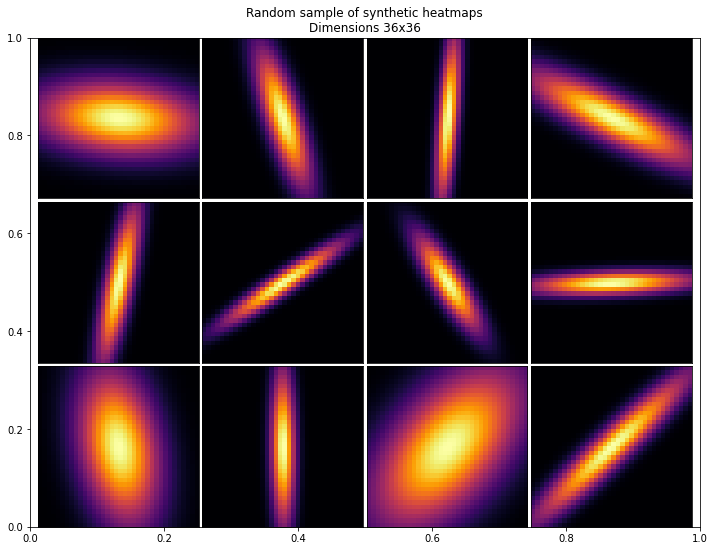

In [24]:
fig, axis = plt.subplots(1,1,figsize=(12,9))
cvals = np.random.randint(0, x_train.shape[0], size = 12)
plot_grid(fig, axis, x_train[cvals,::], (3,4),\
          "Random sample of synthetic heatmaps\nDimensions {0}x{0}".format(36),\
          cmap = "inferno", switch = False )

# Methodology

As following the exposition in Doersch, C. (2016) the VAE aims to maximize the probability of each $X$ in the training set under the entire generative process by using a set of conditional distributions over the latent space. The probability of a given point $X$ can be written in terms of latent points $z$ by using the law of total probability as,

$P(X)=\int P(X|z, \theta)p(z) dz$ 
  
The term $P(X|z, \theta)$ is replaced by a distribution $N(X| f(z, \theta), \sigma)$ with $f(\cdot)$ an arbitrary function. For the prior distribution $p(z)$ the VAE assumes that it comes from a standard multivariate normal distribution. 

The only thing that remains is to find a way to simplify the high dimensional integral. This problem can be approached by repeatedly taking samples from $z$ and then computing the expected value of $P(X|z, \theta)$. However, this approach would be, at the very least, wasteful since for most $z$ usually $P(X|z) \approx 0$. A quick way around is to use a new distribution $Q(z|X)$ that takes a value of $X$ and finds $z$ values that had a high chance of generating the observed point and use that distribution to calculate the expected value.

All that remains is to link the surrogate distribution $Q(z|X)$ with the original probability $P(X|Z)$.

By using variational bayesian methods it can be shown that the log probability of $X$ can be written in terms of the surrogate distribution $Q(z|X)$ as 

$log P(X) - D(Q(z|X) || P(z|X)) = E_{z-Q} log(P(X|z)) - D(Q(z|X) || P(z))$

Where $D(\cdot)$ is used to denote de Kullback-Leibler divergence. 



Now assuming that the model has a high capacity the term $D(Q(z|X) || P(z|X))$ should be close to $0$ and hence the log probability of $X$ is approximately equal to the right hand side of the equation above. 

Note that the first term on the right hand side takes the part of a decoder in the sense that it reconstructs the original inputs based on their latent representation. While the second term is related to the encoder part of the architecture since the distribution $Q(z|X)$ takes the original inputs and transforms them into their latent representations. This second term also has a penalty which tries to make $Q(z|X)$ as close as possible to the original prior. The problem becomes entirely tractable by specifying $Q(\cdot)$ as a gaussian distribution too.

The VAE architecture can be summarised in the following schematic representation. 

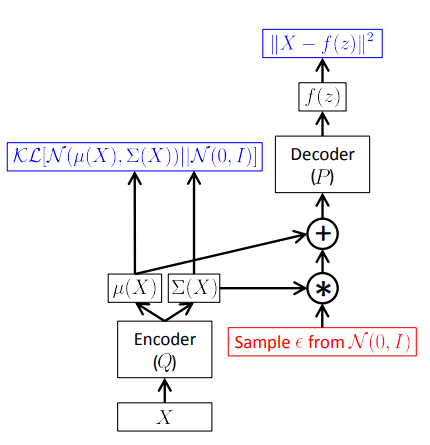

Image taken from Doersch, C. (2016)

## Defintion of the Variational Autoencoder architecture

In [25]:
## Latent Dimension for VAE | AE - We know that data has inherent dimension 3
latent_dim = 3

In [26]:
# Definition of sampling layer for VAE
def Sample(args):
  """ Sampling layer for VAE"""
  z_mean, z_log_sigma = args
  epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                             mean=0.)
  return z_mean + K.exp(z_log_sigma) * epsilon

In [27]:
## Convolutional architecture block
def gen_block(x, units, dp = 0.2, stride = 2):
  """ Taylor made network blocks """
  x = Conv2D(units, (3, 3), padding = 'same', activation = 'relu')(x)
  x = MaxPool2D((2, 2), strides = stride)(x)
  #x = Dropout(dp)(x)
  return x

### Encoder architecture

The following architecture was chosen after several experimentation with different possibilities following roughly the guidelines in Leonov, S., Vasilyev, A., Makovetskii, A., & Kober, V. (2019). I created a mini-block cell composed of a convolutional layer followed by a max pooling one. The network is built using this blocks. The strides and the number of units in each layer can be controlled for further flexibility. 

In this particular case we are interested in keeping track of the test set loss but also we want a model that gives an interpretable embedding in the latent space. Training is done until there is no apparent improvement on the test set loss. 

I also used a scheduler for the step size in the optimizer as this has been shown to improve the results in certain difficult optimization problems. 

In [ ]:
## Encoder architecture
inputs = keras.Input(shape=(36, 36, 1))
e_step = Conv2D(32, 3, activation="relu", strides=1, padding="same")(inputs)
e_step = gen_block(e_step, 64)
e_step = gen_block(e_step, 128)
e_step = gen_block(e_step, 64, stride = 2)
e_step = Flatten()(e_step)
h = Dense(64, activation='relu')(e_step)
z_mean = Dense(latent_dim)(h)
z_log_sigma = Dense(latent_dim)(h)
z = layers.Lambda(Sample)([z_mean, z_log_sigma])
encoder = keras.Model(inputs, [z_mean, z_log_sigma, z], name='encoder')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 36, 36, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 36, 36, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 36, 36, 64)   18496       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 18, 18, 64)   0           conv2d_1[0][0]                   
____________________________________________________________________________________________

### Decoder architecture

In [ ]:
## Decoder
latent_inputs = keras.Input(shape=(latent_dim,))
d_step = Dense(4 * 4 * 64, activation="relu")(latent_inputs)
d_step = Reshape((4, 4, 64))(d_step)
d_step = Conv2DTranspose(64, 3, activation="relu", strides=1, padding="same")(d_step)
d_step = Conv2DTranspose(64, 3, activation="relu", strides=3, padding="same")(d_step)
d_step = Conv2DTranspose(32, 3, activation="relu", strides=3, padding="same")(d_step)
d_output = Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(d_step)
decoder = keras.Model(latent_inputs, [d_output], name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 3)]               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              4096      
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 64)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 4, 4, 64)          36928     
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 12, 12, 64)        36928     
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 36, 36, 32)        18464     
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 36, 36, 1)         289 

### Model

In [ ]:
# VAE Model
outputs = decoder(encoder(inputs)[2])
vae = keras.Model(inputs, outputs, name='vae_mlp')
vae.summary()

# VAE Loss
reconstruction_loss = K.mean(keras.losses.binary_crossentropy(inputs, outputs))
reconstruction_loss *= 36 * 36
kl_loss = 1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma)
kl_loss = K.mean(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = reconstruction_loss + kl_loss
vae.add_loss(vae_loss)

Model: "vae_mlp"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 36, 36, 1)]       0         
_________________________________________________________________
encoder (Functional)         [(None, 3), (None, 3), (N 232454    
_________________________________________________________________
decoder (Functional)         (None, 36, 36, 1)         96705     
Total params: 329,159
Trainable params: 329,159
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Compiling
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    0.001, 30, 0.99, staircase=False, name=None
)
vae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule))

# Fit
vae.fit(x_train, x_train,
        epochs=20,
        batch_size=64,
        validation_data=(x_test, x_test),
        callbacks = [])

Epoch 1/20
149/149 [==============================] - 4s 18ms/step - loss: 697.9962 - val_loss: 509.8893
Epoch 2/20
149/149 [==============================] - 2s 16ms/step - loss: 504.4742 - val_loss: 482.3037
Epoch 3/20
149/149 [==============================] - 2s 16ms/step - loss: 477.2693 - val_loss: 447.7650
Epoch 4/20
149/149 [==============================] - 2s 16ms/step - loss: 450.7219 - val_loss: 442.5604
Epoch 5/20
149/149 [==============================] - 2s 16ms/step - loss: 449.1843 - val_loss: 442.0878
Epoch 6/20
149/149 [==============================] - 2s 16ms/step - loss: 447.9336 - val_loss: 442.0901
Epoch 7/20
149/149 [==============================] - 2s 16ms/step - loss: 451.2275 - val_loss: 441.5805
Epoch 8/20
149/149 [==============================] - 2s 16ms/step - loss: 445.0775 - val_loss: 441.4699
Epoch 9/20
149/149 [==============================] - 2s 16ms/step - loss: 449.4317 - val_loss: 441.4745
Epoch 10/20
149/149 [==============================] - 

In [ ]:
## Further training
vae.fit(x_train, x_train,
        epochs=10,
        batch_size=64,
        validation_data=(x_test, x_test),
        callbacks = [])


Epoch 1/10
149/149 [==============================] - 2s 17ms/step - loss: 447.0835 - val_loss: 440.6263
Epoch 2/10
149/149 [==============================] - 2s 16ms/step - loss: 447.0845 - val_loss: 440.6296
Epoch 3/10
149/149 [==============================] - 2s 16ms/step - loss: 447.0853 - val_loss: 440.6129
Epoch 4/10
149/149 [==============================] - 2s 16ms/step - loss: 447.0804 - val_loss: 440.6130
Epoch 5/10
149/149 [==============================] - 2s 16ms/step - loss: 447.0821 - val_loss: 440.6132
Epoch 6/10
149/149 [==============================] - 2s 16ms/step - loss: 447.0829 - val_loss: 440.6220
Epoch 7/10
149/149 [==============================] - 2s 16ms/step - loss: 447.0821 - val_loss: 440.6098
Epoch 8/10
149/149 [==============================] - 2s 16ms/step - loss: 447.0809 - val_loss: 440.6057
Epoch 9/10
149/149 [==============================] - 2s 16ms/step - loss: 447.0813 - val_loss: 440.6205
Epoch 10/10
149/149 [==============================] - 

Training is done until there is no apparent improvement on the validation loss. 

In [ ]:
# vae.save('/content/drive/My Drive/Colab Notebooks/Models/vae_4821.h5')
# encoder.save('/content/drive/My Drive/Colab Notebooks/Models/encoder_4821.h5')
# decoder.save('/content/drive/My Drive/Colab Notebooks/Models/decoder_4821.h5')

In [28]:
latent_dim = 3
vae = load_model('/content/drive/My Drive/Colab Notebooks/Models/vae_4821.h5')
encoder = load_model('/content/drive/My Drive/Colab Notebooks/Models/encoder_4821.h5')
decoder = load_model('/content/drive/My Drive/Colab Notebooks/Models/decoder_4821.h5')

## Example of decoded images

In [29]:
# Prediction
vae_predict = np.squeeze(vae.predict(x_test, batch_size=32))

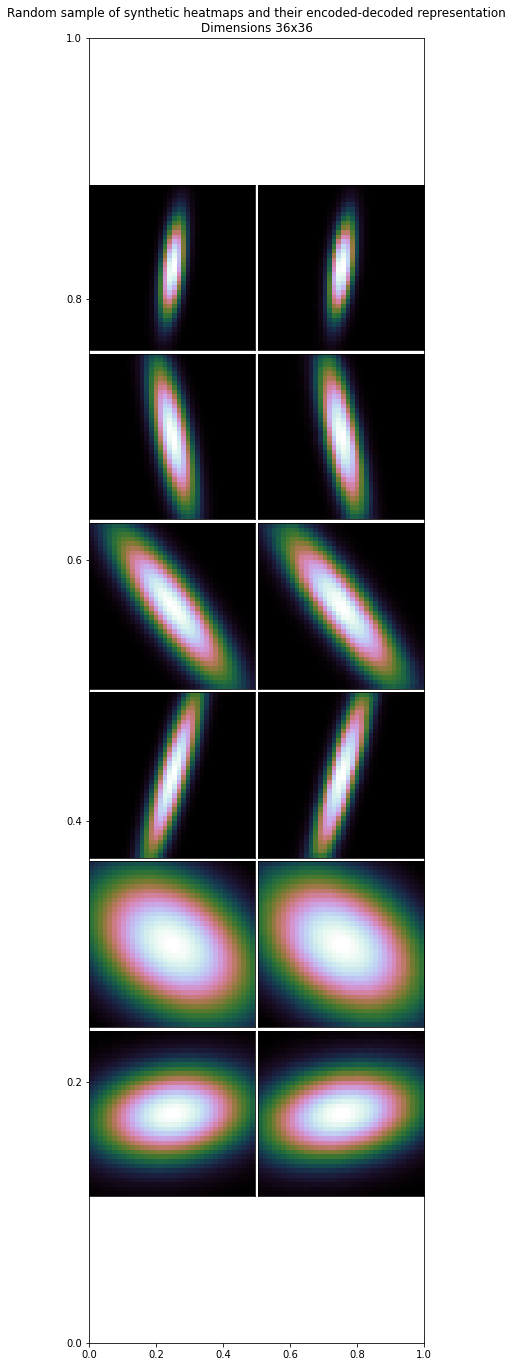

In [ ]:
## Some Encoding examples
np.random.seed(15)
fig, axis = plt.subplots(1,1,figsize=(6,24))
cvals2 = np.random.randint(0, x_test.shape[0], size = 6)
new_arr = np.stack([x_test[cvals2,::], vae_predict[cvals2,::]]).reshape((12,  36 , 36), order = 'F')
new_arr.shape
plot_grid(fig, axis, new_arr, (6, 2),\
          "Random sample of synthetic heatmaps and their encoded-decoded representation\nDimensions {0}x{0}".format(36),\
          cmap = "cubehelix")

## Reconstruction error on test set

In this section I show the average reconstruction error based on the test set measured with the frobenius norm. The measure shown is conditional on a fixed sample. 

In [ ]:
# Prediction
vae_latent, vae_logvar, _, = encoder.predict(x_test, batch_size = 32)
vae_logvar.shape

(2375, 3)

In [ ]:
sim = np.random.normal(size=vae_logvar.shape)
vae_decode = vae_latent + sim * np.exp(vae_logvar)
vae_rec = np.squeeze(decoder.predict(vae_decode,  batch_size = 32))
vae_rec.shape

(2375, 36, 36)

In [ ]:
## VAE Reconstruction error
vae_rec_error = LA.norm(vae_rec - x_test, axis = (1,2))
np.mean(vae_rec_error)

0.32196462

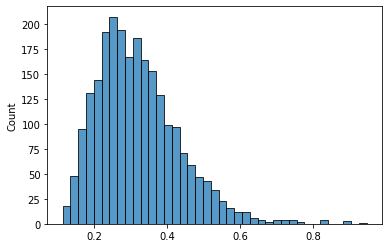

In [ ]:
sns.histplot(vae_rec_error)

# Results

In this section I present the results obtained by exploring the latent space that gets formed by the use of the VAE. 

In [ ]:
## Recover latent space for X
z_mean, z_log_var, z_sample = encoder.predict(x_train)

### 2D

In [ ]:
def twod_plot(x, y, z):
  """ Projections in cartesian axis"""
  fig, ax = plt.subplots(1,3, figsize=(16,8))
  ax[0].scatter(z[:,x], z[:,y], cmap = 'cool', c = y_train[:,0])
  ax[0].set_title("By variance of x")
  ax[1].scatter(z[:,x], z[:,y], cmap = 'cool', c = y_train[:,1])
  ax[1].set_title("By variance of y")
  ax[2].scatter(z[:,x], z[:,y], cmap = 'cool', c = y_train[:,2])
  ax[2].set_title("By correlation")

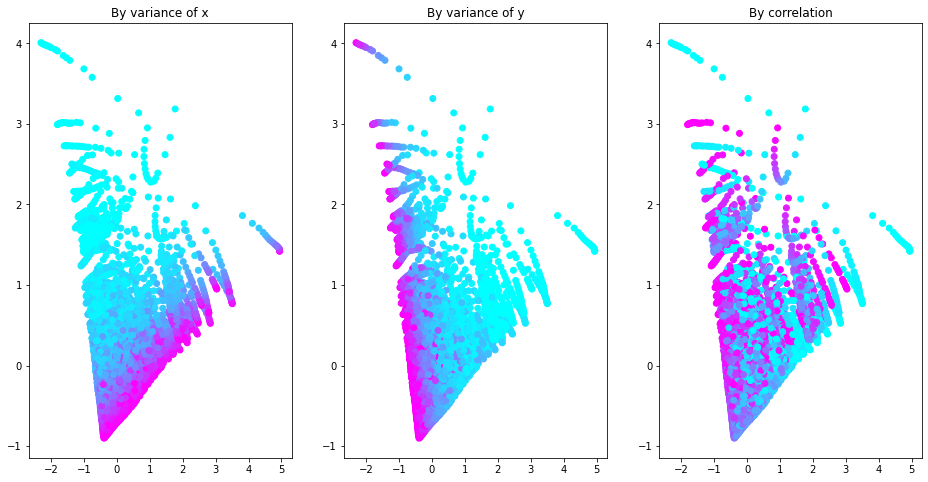

In [ ]:
## First two dimensions
twod_plot(0, 1, z_mean)

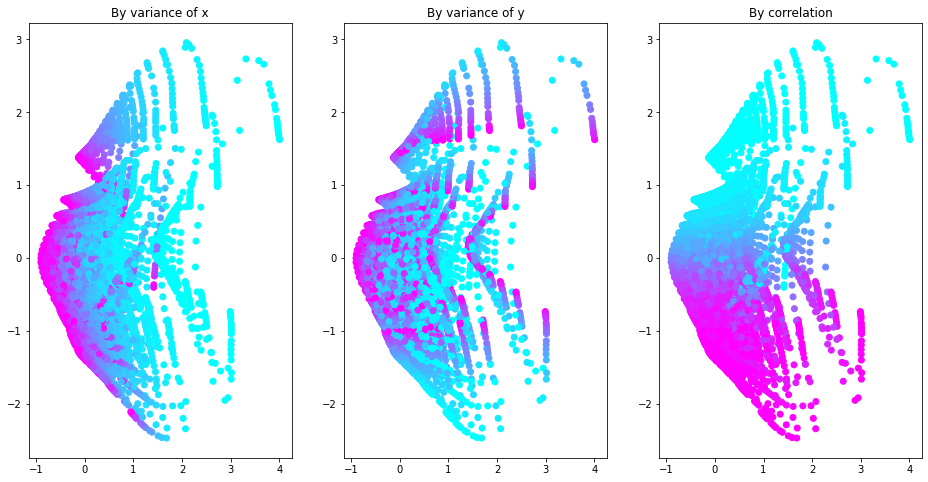

In [ ]:
twod_plot(1, 2, z_mean)

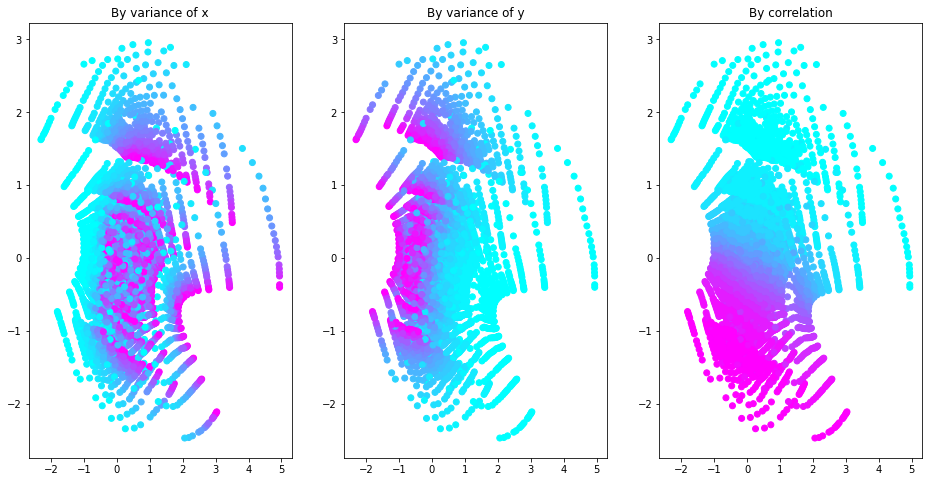

In [ ]:
twod_plot(0, 2, z_mean)

Images above show the projections on the cartesian axis of the obtained manifold in the latent space. Colors represent how the three characteristics of the covariance matrix change as we move through the space. 

The separation for the correlation is evident when projecting on the $x-z$ axis. We note that directions to the south are related to lower correlations while those that point to the north are related to higher correlations. The variance of the components is also separated less sharply by the bisection of the projected figure. 


The projection on the $x-y$ axis shows a sharper separation of the points according to the variances of the first and the second components towards the edges of the figure. 

#### 2D Directions

##### Useful functions

In [ ]:
def create_trajectory(z1, z2, num):
  """ Num is used to sample the given number of points, 
  space creates the convex combination. Takes num points equally spaced
  in the axis from z1 to z2"""
  space = np.linspace(0,1,num)
  traj = np.zeros((len(space), z1.shape[0]))
  for i, s in enumerate(space):
    traj[i] = z1*s + (1-s)*z2
  return traj

In [ ]:
def generate_images(models, samples):
  """ Takes the decoder and decodes the sampled points from the latent space obtained 
  with the trajectory function"""
  return np.array([np.squeeze(m.predict(samples)) for m in models])

In [ ]:
def alternating(points, i):
    """Get a vector perpendicular to the given trajectory"""
    dir = points[1] - points[0]
    v = np.ones_like(dir)
    if dir[1] != 0:
        v[1] = -dir[0]/dir[1]
    else:
        v[0] = -dir[1]/dir[0]
    v = v / np.linalg.norm(v)
    return (-1)**i * v

In [ ]:
def plot_data_and_generated_images(ax, X_points, dimension, labels, sample_coords, sample_im, im_dir_func,\
                                   cmap_points = "viridis", alpha_points = 0.3, c_samples='r', off = 100, \
                                   title = "Generated images"):
    """ Takes latent spaces points, dimensions, labels, trajectory coordinates, images sampled from the trajectory, 
    and a function to redirect vectors. Plots the scatter plus embedded images"""

    ## Plot scatter    
    a, b = dimension
    ax.scatter(X_points[:,a], X_points[:,b], c = labels.astype('float32'), \
               cmap = cmap_points, alpha=alpha_points)
    ax.scatter(sample_coords[:,a], sample_coords[:,b], c = c_samples, linewidths=2)
   
    ## Plot embedded images
    for i, x in enumerate(sample_im):
        im = OffsetImage(x, zoom=0.8, cmap='cool')
        im.image.axes = ax
        dir = im_dir_func(sample_coords[:,[a,b]], i)# [[a, b]]
        off_length = off
        ab = AnnotationBbox(im, sample_coords[i][[a, b]],
                            xybox=dir*off_length,
                            xycoords='data',
                            boxcoords="offset points",
                            pad=0.3,
                            arrowprops=dict(arrowstyle="->"))
        ax.add_artist(ab)
    ax.set_title(title)

#### Lines on 0-2 axis

In [ ]:
# VAE exploration

## Initial point
base = np.array([0, 0, 2.5])

## Direction
dir_vae = np.array([0.2, 0, -1])
dir_vae = dir_vae / np.linalg.norm(dir_vae)
span = 4

## Pair of Vectors
z1 = dir_vae + base
z2 = dir_vae * span + base
size_traj = 5

## Define trajectories
traj = create_trajectory(z1, z2, size_traj)

## Generate images in the trajectory
images_gen = np.squeeze(generate_images([decoder], traj))

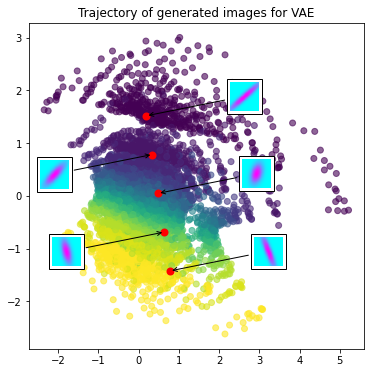

In [ ]:
fig, ax = plt.subplots(1,1, figsize = (6,6))
title = "Trajectory of generated images for {1}".format(size_traj, "VAE")
a = plot_data_and_generated_images(ax, z_sample, (0,2), y_train[:,2], traj,\
                               images_gen, alternating,\
                                cmap_points = "viridis", alpha_points = 0.6, c_samples='r',
                               title = title, off = 100)
plt.show()

In the figure above we can get a sense on how the heatmaps rotate as the correlation is modified. The chosen direction is evidently capturing this aspect of the data.  

#### Lines on 0-1 axis

In [ ]:
## Initial point
base = np.array([3.3, 0.5, 0])

## Direction
dir_vae = np.array([-1, 0, 0])
dir_vae = dir_vae / np.linalg.norm(dir_vae)
span = 4

## Pair of Vectors
z1 = dir_vae + base
z2 = dir_vae * span + base
size_traj = 4
(z1, z2)

## Define trajectories
traj = create_trajectory(z1, z2, size_traj)

## Generate images in the trajectory
images_gen = np.squeeze(generate_images([decoder], traj))

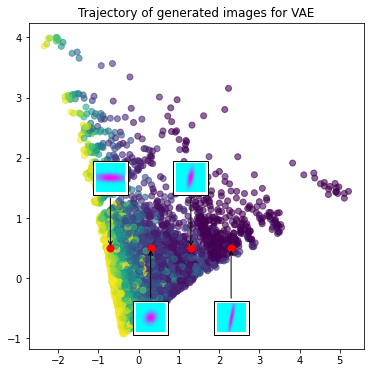

In [ ]:
fig, ax = plt.subplots(1,1, figsize = (6,6))
title = "Trajectory of generated images for {1}".format(size_traj, "VAE")
a = plot_data_and_generated_images(ax, z_sample, (0, 1), y_train[:,1], traj,\
                               images_gen, alternating,\
                                cmap_points = "viridis", alpha_points = 0.6, c_samples='r',
                               title = title, off = 70)
plt.show()

A horizontal line trajectory is shown on the projected $x-y$ space. In this case we can see that the direction represents changes in the variance of the components. It starts on a wide ellipse with a higher variance on the x-component and slowly transforms into a longer ellipse with increasing variance in the y-component. 

#### Angular Directions

In [ ]:
def create_trajectory_rotation(z1, theta, num, base = 0, missing = 'x'):
  """ Create a trajectory from a given point using a rotation matrix"""
  R = np.array([[np.cos(theta), -np.sin(theta), 0],[np.sin(theta), np.cos(theta), 0], [0, 0, 0]])
  if missing == 'x':
    ind = [2, 0, 1]
  elif missing == 'y':
    ind = [0, 2, 1]
  else:
    ind = [0, 1, 2]
  mat = np.eye(3)[ind,] 
  R = mat @ R @ mat.T
  traj = np.zeros((num, z1.shape[0]))
  z = z1
  for i in range(num):
      traj[i] = z + base
      z = R @ z
  return traj

In [ ]:
## Rotation trajectory
z1, theta, size_traj = np.array([0, 0, 2]), np.pi/180 * 70, 5
base = np.array([0, 0, 0])
traj = create_trajectory_rotation(z1, theta, size_traj, base, missing = "y") / 2
traj


array([[ 0.        ,  0.        ,  1.        ],
       [-0.93969262,  0.        ,  0.34202014],
       [-0.64278761,  0.        , -0.76604444],
       [ 0.5       ,  0.        , -0.8660254 ],
       [ 0.98480775,  0.        ,  0.17364818]])

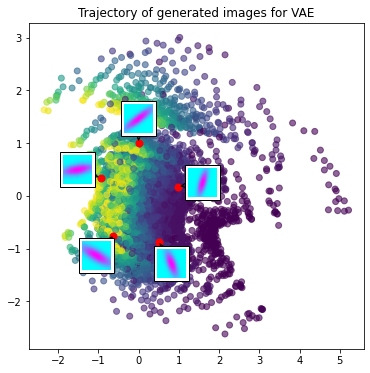

In [ ]:

## Generate images in the trajectory
images_gen = np.squeeze(generate_images([decoder], traj))

fig, ax = plt.subplots(1,1, figsize = (6,6))
title = "Trajectory of generated images for {1}".format(size_traj, "VAE")
a = plot_data_and_generated_images(ax, z_sample, (0,2), y_train[:,1], traj,\
                               images_gen, lambda points, i: points[i]/np.linalg.norm(points[i])*0.5,\
                                cmap_points = "viridis", alpha_points = 0.6, c_samples='r',
                               title = title, off = 50)
plt.show()

The figure above shows a particular angular direction in the $x-z$ projected space. We can see how a rotation in the latent space is reflected in a similar way in the decoded heatmaps. 

### 3D

#### Projections on coordinate axis

In [ ]:
def plot_latent_3d(latent, labels, type_plot = "projections", view_angles = (30,45), cmap = 'cool', alpha = 0.3, pad = 1, grid = True, title = "3D plot of the latent space", ax = None):
    
    ## In case no ax argument is passed
    if ax is None:
        fig = plt.figure(figsize=(8,8))
        ax = fig.add_subplot(111, projection='3d')

    ## Dimensions
    dims = {0:'x', 1:'y', 2:'z'}
    opts = 'black' if type_plot == 'all' else labels

    ## Scatter plots
    if type_plot in ["all", "only_points"]:
        ax.scatter(xs = latent[:,0], ys = latent[:,1], zs = latent[:,2], c = labels, cmap = cmap, alpha = alpha)

    ## For projections
    if type_plot in ["projections", "all"]:
        for i in range(2):
            for j in range(i+1,3):
                other = (2*i-j)%3
                ax.scatter(xs = latent[:,i], ys = latent[:,j], zs=min(latent[:,other])-pad, zdir=dims[other], c = opts, cmap = cmap, alpha = alpha)

    ax.view_init(*view_angles)

    ## Labels 
    ax.set_xlabel('z1')
    ax.set_ylabel('z2')
    ax.set_zlabel('z3')
    ax.set_xlim(min(latent[:,0])-pad, max(latent[:,0])+pad)
    ax.set_ylim(min(latent[:,1])-pad, max(latent[:,1])+pad)
    ax.set_zlim(min(latent[:,2])-pad, max(latent[:,2])+pad)
    ax.grid(grid)
    ax.set_title(title)

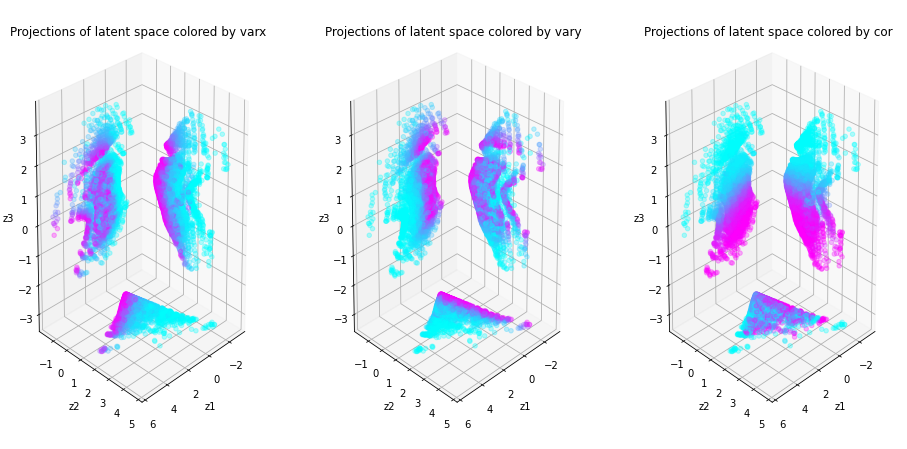

In [ ]:
view_angles = (20,45)
fig = plt.figure(figsize=(16,8))
ax1 = fig.add_subplot(131, projection='3d')
ax2 = fig.add_subplot(132, projection='3d')
ax3 = fig.add_subplot(133, projection='3d')

plot_latent_3d(z_sample, y_train[:,0], type_plot = "projections", view_angles = view_angles,\
               cmap = 'cool', alpha = 0.3, pad = 1, grid = True, \
               title = "Projections of latent space colored by varx", ax = ax1)

plot_latent_3d(z_sample, y_train[:,1], type_plot = "projections", view_angles = view_angles,\
               cmap = 'cool', alpha = 0.3, pad = 1, grid = True, \
               title = "Projections of latent space colored by vary", ax = ax2)

plot_latent_3d(z_sample, y_train[:,2], type_plot = "projections", view_angles = view_angles,\
               cmap = 'cool', alpha = 0.3, pad = 1, grid = True, \
               title = "Projections of latent space colored by cor", ax = ax3)

Plots above show the $2D$ projections shown in the section before in the original latent space. 

#### 3D Space

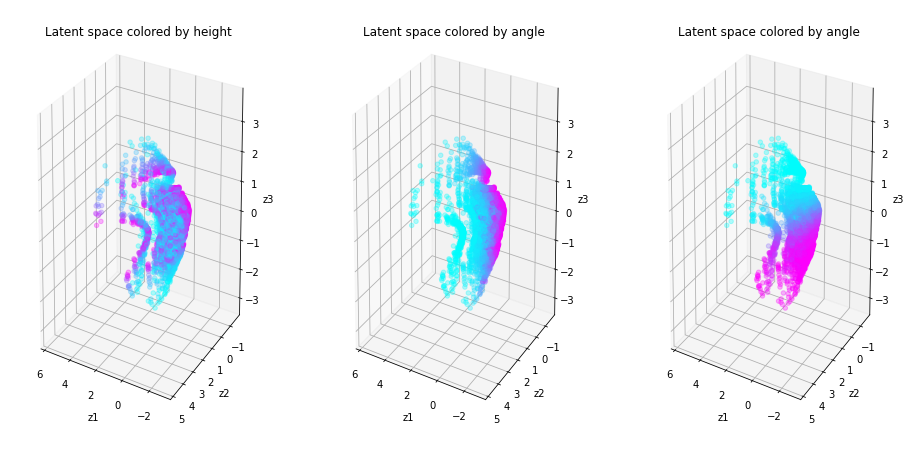

In [ ]:
fig = plt.figure(figsize=(16,8))

view_angles = (20,120)
ax1 = fig.add_subplot(131, projection='3d')
ax2 = fig.add_subplot(132, projection='3d')
ax3 = fig.add_subplot(133, projection='3d')

plot_latent_3d(z_sample, y_train[:,0], type_plot = "only_points", view_angles = view_angles,\
               cmap = 'cool', alpha = 0.3, pad = 1, grid = True, \
               title = "Latent space colored by height", ax = ax1)

plot_latent_3d(z_sample, y_train[:,1], type_plot = "only_points", view_angles = view_angles,\
               cmap = 'cool', alpha = 0.3, pad = 1, grid = True, \
               title = "Latent space colored by angle", ax = ax2)

plot_latent_3d(z_sample, y_train[:,2], type_plot = "only_points", view_angles = view_angles,\
               cmap = 'cool', alpha = 0.3, pad = 1, grid = True, \
               title = "Latent space colored by angle", ax = ax3)

Plot of the 3D manifold colored by latent characteristics.

#### Interactive Plots

In [ ]:
## Create dataframe to build interactive plot 
df = pd.DataFrame(z_sample)
df = pd.concat([df, pd.DataFrame(y_train)], axis=1)
df.columns = ["x", "y", "z", "var_x", "var_y", "cor"]
df["diff"] = np.abs(df.var_x - df.var_y)

df.head()

x         y         z  var_x  var_y   cor  diff
0 -0.044789 -0.486422  0.577576    4.1    4.3 -0.75   0.2
1 -0.217046 -0.125016  0.076529    1.5    2.5 -0.15   1.0
2 -0.255875  0.115033  0.077926    0.9    2.3 -0.15   1.4
3 -0.734292  0.521104 -0.726132    0.9    3.9  0.75   3.0
4  0.058673  0.145950 -1.063448    2.3    1.5  0.75   0.8

In [ ]:
## With plotly
fig = px.scatter_3d(df, x='x', y='y', z='z',
              color='diff')
fig.show()

In [ ]:
fig = px.scatter_3d(df, x='x', y='y', z='z',
              color='cor')
fig.show()

Plots above show the manifold generated by the VAE in the latent space. The figures are colored by both the correlation and the difference in the variance between the components. 

We note that the height of the point in the $z$ axis is directly related to the correlation. A simple trajectory that moves from north to south spans the complete available values for the correlation parameter. 

Coloring by the difference between the variances we note that points that represent heatmaps with relatively big differences of the components are located in the sides of the manifold, towards the exterior. The central part of the manifold represents images where both components have a similar variance. This is confirmed by the projections on the 2D axis shown above. We note that points on the east of the first axis have a relatively higher variance on the first component while those of the west have a higher variance on the second. 

### Exploration based on specific directions on 3D

In this section I explore the two directions that seem to have a more straightforward interpretation in terms of encoded characteristics of the input images.

The first direction is obtained by transversing the convex hull of the manifold along the center which has a thin line of points that represent images with isovariances in both components (see the blue line in the plot above).

The second one is by finding the planes that bound the manifold in the $y-z$ directions both from above and below (x constant).

#### Convex Hull Isovariance

To find the convex hull of the manifold along the isovariance strip I filter data by difference in variances, bin for different values of $z$ and calculate splines to link both the $x-z$ axis and the $y-z$ axis. 

In [ ]:
df.sort_values(["y"], ascending = True).head()

x         y         z  var_x  var_y   cor  diff
6043 -0.366410 -0.897348  0.045032    4.9    4.9 -0.15   0.0
2833 -0.353682 -0.896278 -0.086667    4.9    4.7  0.05   0.2
8704 -0.351516 -0.888245  0.132846    4.9    4.9 -0.25   0.0
121  -0.406912 -0.885594 -0.125882    4.9    4.7  0.15   0.2
21   -0.379064 -0.885013  0.073298    4.7    4.9 -0.15   0.2

In [ ]:
## This is to extract the points in the convex hull of the manifold while fixing z = 0
## hence this takes out the line of points where var x = var y but corr is changing 
use_data = df[df["diff"] < 0.3].sort_values(["z"],ascending = True)
use_data["zdiscr"] = pd.cut(use_data.z, 100)

In [ ]:
## Take out the max by bin cutting in order to get the convex hull 
hull_data = use_data[["x","y", "zdiscr", "z"]].groupby("zdiscr").agg({'x':'mean','y':'min','z':'mean'})
hull_data = hull_data.sort_values(["z"])
hull_data = hull_data[~np.isnan(hull_data.z)]

In [ ]:
## Bins in the convex hull
hull_data

x         y         z
zdiscr                                        
(-2.355, -2.296]  0.390589  1.685157 -2.331358
(-2.242, -2.187] -0.053442  1.638835 -2.209558
(-2.187, -2.133]  0.337053  1.378114 -2.156759
(-2.025, -1.97]   0.498719  1.111634 -2.011627
(-1.916, -1.862] -0.010978  0.913913 -1.893945
...                    ...       ...       ...
(2.694, 2.748]    2.117230  1.714333  2.702075
(2.748, 2.802]    1.053202  1.285589  2.793964
(2.857, 2.911]    1.408419  1.580391  2.883152
(2.911, 2.965]    1.650815  1.932635  2.918497
(3.019, 3.074]    1.115057  2.147863  3.073616

[91 rows x 3 columns]

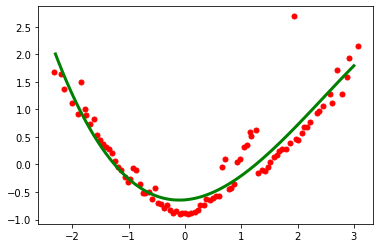

In [ ]:
## Use a spline to estimate the convex hull fixing z
plt.plot(hull_data["z"], hull_data["y"], 'ro', ms=5)
spl_y = UnivariateSpline(hull_data["z"], hull_data["y"])
xs = np.linspace(-2.3, 3, 100)
spl_y.set_smoothing_factor(14)
plt.plot(xs, spl_y(xs), 'g', lw=3)
plt.show()

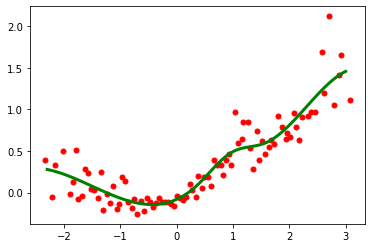

In [ ]:
## Use a spline to estimate the convex hull fixing y 
plt.plot(hull_data["z"], hull_data["x"], 'ro', ms=5)
spl_z = UnivariateSpline(hull_data["z"], hull_data["x"])
spl_z.set_smoothing_factor(3)
plt.plot(xs, spl_z(xs), 'g', lw=3)
plt.show()

In [ ]:
## Use splines to get the needed direction
grid = np.concatenate([np.linspace(-2.2, -1, 4), np.linspace(-1, 0, 6),  np.linspace(0, 0.7, 6), np.linspace(0.7, 3, 4)])
y_g = spl_y(grid)
z_g = spl_z(grid)
#z_g = np.linspace(0.3, -0.3, 12)
grid_lat = np.array([z_g, y_g, grid]).T
np.round(grid_lat, 3)

array([[ 0.262,  1.745, -2.2  ],
       [ 0.167,  0.856, -1.8  ],
       [ 0.045,  0.194, -1.4  ],
       [-0.067, -0.262, -1.   ],
       [-0.067, -0.262, -1.   ],
       [-0.109, -0.419, -0.8  ],
       [-0.136, -0.533, -0.6  ],
       [-0.143, -0.607, -0.4  ],
       [-0.126, -0.642, -0.2  ],
       [-0.081, -0.642,  0.   ],
       [-0.081, -0.642,  0.   ],
       [-0.03 , -0.622,  0.14 ],
       [ 0.039, -0.588,  0.28 ],
       [ 0.125, -0.539,  0.42 ],
       [ 0.225, -0.476,  0.56 ],
       [ 0.326, -0.402,  0.7  ],
       [ 0.326, -0.402,  0.7  ],
       [ 0.572,  0.186,  1.467],
       [ 0.977,  0.967,  2.233],
       [ 1.455,  1.791,  3.   ]])

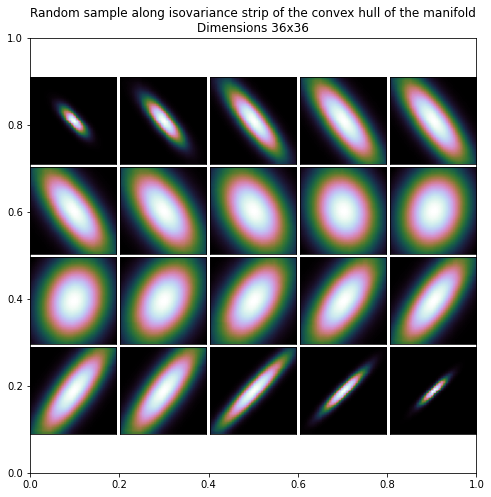

In [ ]:
## Generating from the specific direction
images_gen = np.squeeze(generate_images([decoder], grid_lat))
fig, axis = plt.subplots(1,1,figsize=(8, 8))
plot_grid(fig, axis, images_gen, (4, 5),\
          "Random sample along isovariance strip of the convex hull of the manifold\nDimensions {0}x{0}".format(36),\
          cmap = "cubehelix")

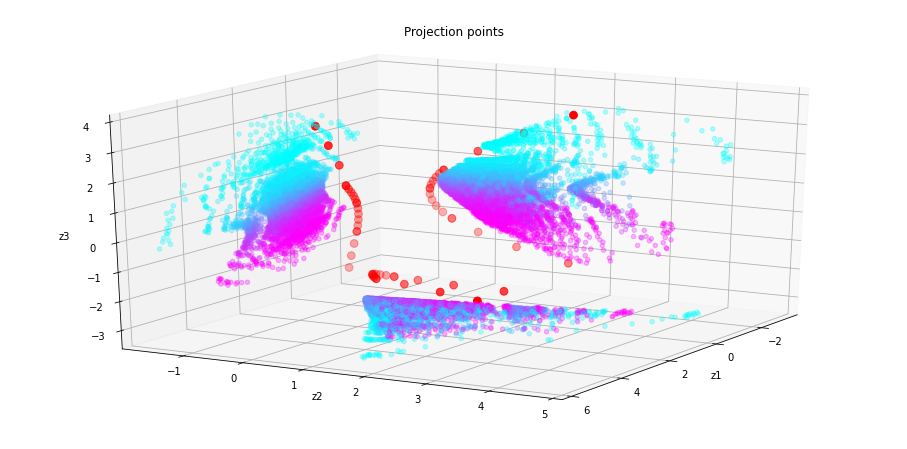

In [ ]:
fig = plt.figure(figsize=(16,8))

view_angles = (20,80)
ax1 = fig.add_subplot(111, projection='3d')
#ax2 = fig.add_subplot(132, projection='3d')
#ax3 = fig.add_subplot(133, projection='3d')

plot_latent_3d(z_sample, y_train[:,2], type_plot = "projections", view_angles = [20, 30],\
               cmap = 'cool', alpha = 0.3, pad = 1, grid = True, \
               title = "Projection points", ax = ax1)
ax1.scatter(min(z_sample[:,0]),grid_lat[:,1], grid_lat[:,2] , c='r', s = 60)
ax1.scatter(grid_lat[:,0], min(z_sample[:,1]), grid_lat[:,2] , c='r', s = 60)
ax1.scatter(grid_lat[:,0], grid_lat[:,1], min(z_sample[:,2]) , c='r', s = 60)
plt.show()

The plot above show the sample of points that were reconstructed through the decoder. Reconstructed images are shown above too. It's hard to be completely accurate on the correct path to transverse to maintain the variance fixed however we can get sense that this direction of the manifold is related to changes in correlation. As can be seen in the plots above the correlation passes from its most negative value to its most positive one. It's easy to check the movement on the decoded images as this feature is related to the rotation of the ellipse.

#### Bounding planes - Diminishing variance

For this section I create a set of planes to bound the manifold from above and from below in the $y-z$ direction. 

In [ ]:
## Define a plane to cut the manifold from above
p1 = np.array([-0.3371, -0.9176, 0.1308])
#p2 = np.array([0.4887, 0.1992, 1.6604])
p2 = np.array([0.93, 0.91, 2.37])
#p3 = np.array([0.0388, 0.08, 0.9140])
p3 = np.array([0.46, -0.31, 0.80])
norm = np.cross(p1 - p2, p1 - p3)
k = -np.dot(norm, p1)
np.dot(norm, p1) + k

0.0

In [ ]:
def get_zcoord(vec, plane, index = [0,1]):
  """ Given two coordinates of a plane recovers the third one"""
  norm, k = plane
  miss = set(range(3)) - set(index)
  val = (-k - np.dot(np.array(vec), norm[index]))/norm[np.array([int(x) for x in miss])]
  return np.concatenate([vec, val])

res2 = get_zcoord((0.33, 1.5), (norm, k))
# res2 p3
traj = create_trajectory(res2, p1, 16)

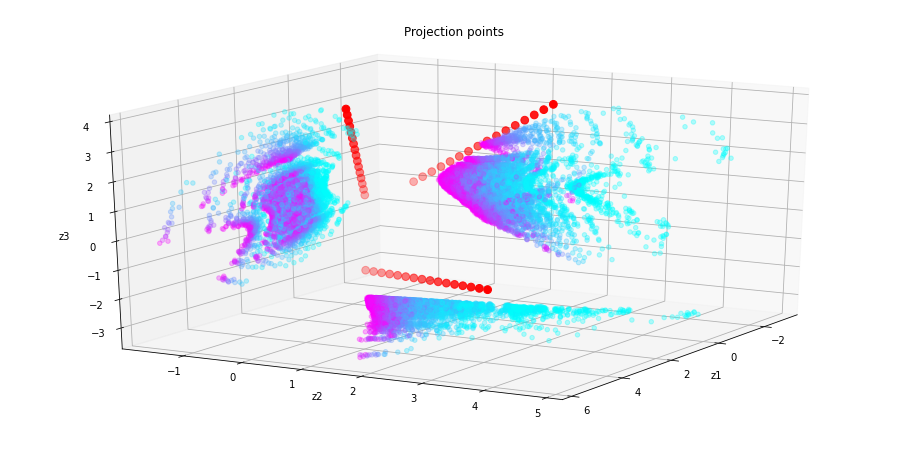

In [ ]:
fig = plt.figure(figsize=(16,8))

view_angles = (20,120)
ax1 = fig.add_subplot(111, projection='3d')
#ax2 = fig.add_subplot(132, projection='3d')
#ax3 = fig.add_subplot(133, projection='3d')

plot_latent_3d(z_sample, y_train[:,0], type_plot = "projections", view_angles = [20, 30],\
               cmap = 'cool', alpha = 0.3, pad = 1, grid = True, \
               title = "Projection points", ax = ax1)
ax1.scatter(min(z_sample[:,0]),traj[:,1], traj[:,2] , c='r', s = 60)
ax1.scatter(traj[:,0], min(z_sample[:,1]), traj[:,2] , c='r', s = 60)
ax1.scatter(traj[:,0], traj[:,1], min(z_sample[:,2]) , c='r', s = 60)
plt.show()

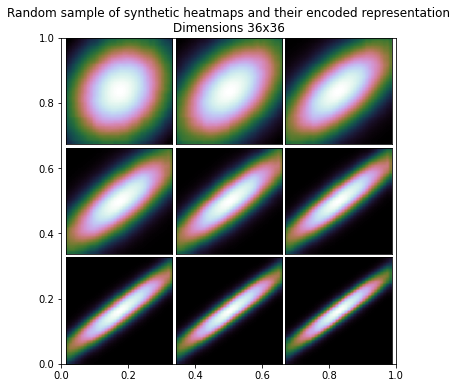

In [ ]:
images_gen = np.squeeze(generate_images([decoder], traj))
fig, axis = plt.subplots(1,1,figsize=(6, 6))
plot_grid(fig, axis, images_gen, (3, 3),\
          "Random sample of synthetic heatmaps and their encoded representation\nDimensions {0}x{0}".format(36),\
          cmap = "cubehelix")

We can see that in the direction of the top bounding plane the variance of the first component remains fixed as well as the correlation while the variance of the second component decreases. This translate in a progressive decrease in the width of the ellipse passing from almost a circular shape to a very sharp figure. 

In [ ]:
## Define a plane to cut the manifold from below
#p1 = np.array([-0.3371, -0.9176, 0.1308])
p1 = np.array([-0.38, -0.8, -0.04])
#p2 = np.array([-0.3998, -0.3484, -0.7691])
p2 = np.array([0.14, -1.18, -0.38])
p3 = np.array([0.1758, 0.7837, -1.8982])
norm = np.cross(p1 - p2, p1 - p3)
k = -np.dot(norm, p1)
np.dot(norm, p1) + k

0.0

In [ ]:
res2 = get_zcoord((-0.32, 0.98), (norm, k))
traj = create_trajectory(p1, res2, 9)

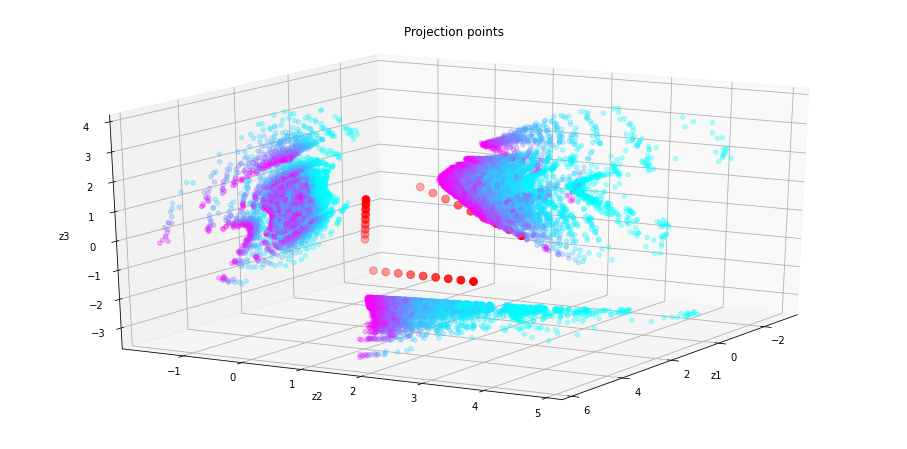

In [ ]:
fig = plt.figure(figsize=(16,8))

view_angles = (20,120)
ax1 = fig.add_subplot(111, projection='3d')
#ax2 = fig.add_subplot(132, projection='3d')
#ax3 = fig.add_subplot(133, projection='3d')

plot_latent_3d(z_sample, y_train[:,0], type_plot = "projections", view_angles = [20, 30],\
               cmap = 'cool', alpha = 0.3, pad = 1, grid = True, \
               title = "Projection points", ax = ax1)
ax1.scatter(min(z_sample[:,0]),traj[:,1], traj[:,2] , c='r', s = 60)
ax1.scatter(traj[:,0], min(z_sample[:,1]), traj[:,2] , c='r', s = 60)
ax1.scatter(traj[:,0], traj[:,1], min(z_sample[:,2]) , c='r', s = 60)
plt.show()

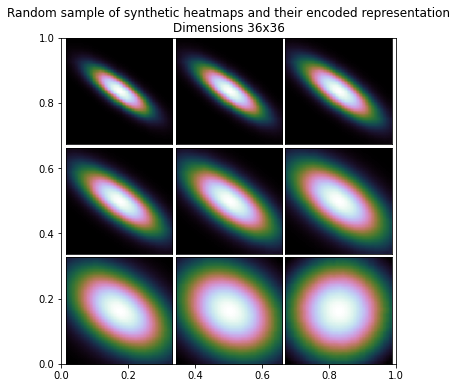

In [ ]:
images_gen = np.squeeze(generate_images([decoder], traj))
fig, axis = plt.subplots(1,1,figsize=(6, 6))
plot_grid(fig, axis, images_gen, (3, 3),\
          "Random sample of synthetic heatmaps and their encoded representation\nDimensions {0}x{0}".format(36),\
          cmap = "cubehelix")

The bounding plane from below shows a similar pattern, variance of the second component increases progressively as we transverse the plane in a northbound direction. This happens while mantaining the negative correlation fixed this is similar to what we saw in the last case but that one was having a positive correlation. 

## Comparing with traditional autoencoder

In this section I estimated a traditional autoencoder with a similar architecture to the VAE in order to compare the latent space generated in both cases.

### Definition of autoencoder

#### Encoder architecture

In [ ]:
## Same block unit as the one used in the VAE

# Convolutional architecture block
def gen_block(x, units, dp = 0.2, stride = 2):
  x = Conv2D(units, (3, 3), padding = 'same', activation = 'relu')(x)
  x = MaxPool2D((2, 2), strides = stride)(x)
  #x = Dropout(dp)(x)
  return x

In [ ]:
## Encoder architecture
inputs = keras.Input(shape=(36, 36, 1))
e_step = Conv2D(32, 3, activation="relu", strides=1, padding="same")(inputs)
e_step = gen_block(e_step, 64)
e_step = gen_block(e_step, 128)
e_step = gen_block(e_step, 64, stride = 2)
e_step = Flatten()(e_step)
h = Dense(64, activation='relu')(e_step)
z = Dense(latent_dim)(h)
encoder_t = keras.Model(inputs, z, name='encoder')
encoder_t.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 36, 36, 1)]       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 36, 36, 32)        320       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 36, 36, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 18, 18, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 18, 18, 128)       73856     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 9, 9, 128)         0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 9, 9, 64)          7379

#### Decoder architecture

In [ ]:
## Decoder architecture
latent_inputs = keras.Input(shape=(latent_dim,))
d_step = Dense(4 * 4 * 64, activation="relu")(latent_inputs)
d_step = Reshape((4, 4, 64))(d_step)
d_step = Conv2DTranspose(64, 3, activation="relu", strides=1, padding="same")(d_step)
d_step = Conv2DTranspose(64, 3, activation="relu", strides=3, padding="same")(d_step)
d_step = Conv2DTranspose(32, 3, activation="relu", strides=3, padding="same")(d_step)
d_output = Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(d_step)
decoder_t = keras.Model(latent_inputs, [d_output], name="decoder")
decoder_t.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 3)]               0         
_________________________________________________________________
dense_6 (Dense)              (None, 1024)              4096      
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 64)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 4, 4, 64)          36928     
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 12, 12, 64)        36928     
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 36, 36, 32)        18464     
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 36, 36, 1)         289 

#### Model

In [ ]:
# AE Model
outputs = decoder_t(encoder_t(inputs))
ae = keras.Model(inputs, outputs, name='ae_mlp')
ae.summary()

# AE Loss
reconstruction_loss = K.mean(keras.losses.binary_crossentropy(inputs, outputs))
ae.add_loss(reconstruction_loss)

Model: "ae_mlp"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 36, 36, 1)]       0         
_________________________________________________________________
encoder (Functional)         (None, 3)                 232259    
_________________________________________________________________
decoder (Functional)         (None, 36, 36, 1)         96705     
Total params: 328,964
Trainable params: 328,964
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Compiling
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    0.001, 30, 0.98, staircase=False, name=None
)
ae.compile(optimizer=tf.keras.optimizers.Adam())

# Fit
ae.fit(x_train, x_train,
        epochs=20,
        batch_size=64,
        validation_data=(x_test, x_test),
        callbacks = [])

Epoch 1/20
149/149 [==============================] - 6s 34ms/step - loss: 0.5330 - val_loss: 0.3571
Epoch 2/20
149/149 [==============================] - 5s 30ms/step - loss: 0.3487 - val_loss: 0.3427
Epoch 3/20
149/149 [==============================] - 4s 30ms/step - loss: 0.3469 - val_loss: 0.3410
Epoch 4/20
149/149 [==============================] - 4s 30ms/step - loss: 0.3447 - val_loss: 0.3408
Epoch 5/20
149/149 [==============================] - 5s 30ms/step - loss: 0.3445 - val_loss: 0.3405
Epoch 6/20
149/149 [==============================] - 5s 30ms/step - loss: 0.3440 - val_loss: 0.3408
Epoch 7/20
149/149 [==============================] - 4s 30ms/step - loss: 0.3417 - val_loss: 0.3402
Epoch 8/20
149/149 [==============================] - 4s 30ms/step - loss: 0.3445 - val_loss: 0.3402
Epoch 9/20
149/149 [==============================] - 5s 31ms/step - loss: 0.3427 - val_loss: 0.3406
Epoch 10/20
149/149 [==============================] - 4s 30ms/step - loss: 0.3439 - val_lo

In [ ]:
## Train small epochs to check evolution
ae.fit(x_train, x_train,
        epochs=5,
        batch_size=64,
        validation_data=(x_test, x_test),
        callbacks = [])


Epoch 1/5
149/149 [==============================] - 5s 33ms/step - loss: 0.3434 - val_loss: 0.3399
Epoch 2/5
149/149 [==============================] - 5s 32ms/step - loss: 0.3435 - val_loss: 0.3400
Epoch 3/5
149/149 [==============================] - 5s 32ms/step - loss: 0.3433 - val_loss: 0.3400
Epoch 4/5
149/149 [==============================] - 5s 32ms/step - loss: 0.3434 - val_loss: 0.3398
Epoch 5/5
149/149 [==============================] - 5s 32ms/step - loss: 0.3437 - val_loss: 0.3400


In [ ]:
## Saving AE
#ae.save('/content/drive/My Drive/Colab Notebooks/ae_model_3636.h5', save_format = "tf")
#decoder_t.save('/content/drive/My Drive/Colab Notebooks/decoder_t_model_3636.h5', save_format = "tf")
#encoder_t.save('/content/drive/My Drive/Colab Notebooks/encoder_t_model_3636.h5', save_format = "tf")

In [ ]:
## Load Models
ae = load_model('/content/drive/My Drive/Colab Notebooks/ae_model_3636.h5')
encoder_t = load_model('/content/drive/My Drive/Colab Notebooks/encoder_t_model_3636.h5')
decoder_t = load_model('/content/drive/My Drive/Colab Notebooks/decoder_t_model_3636.h5')

### Reconstruction error on test set

In [ ]:
# Prediction
ae_latent = encoder_t.predict(x_test, batch_size = 32)
ae_latent.shape

(2375, 3)

In [ ]:
ae_decode = ae_latent + sim * 1 * np.exp(vae_logvar)
ae_rec = np.squeeze(decoder_t.predict(ae_decode,  batch_size = 32))
ae_rec.shape

(2375, 36, 36)

In [ ]:
## VAE Reconstruction error
ae_rec_error = LA.norm(ae_rec - x_test, axis = (1,2))
np.mean(ae_rec_error)

0.25596395

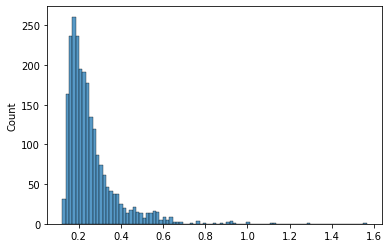

In [ ]:
sns.histplot(ae_rec_error)

This is the reconstruction error on the test set for the autoencoder. As we can see results are on average better than the ones obtained through the VAE. However, we see that the distribution is heavy tailed.

The heavy tailedness shows that there are a set of particular images in the test for which the model doesn't fit too well. In particular the decoded images in these cases are very different from the original ones.

### Example of decoded images

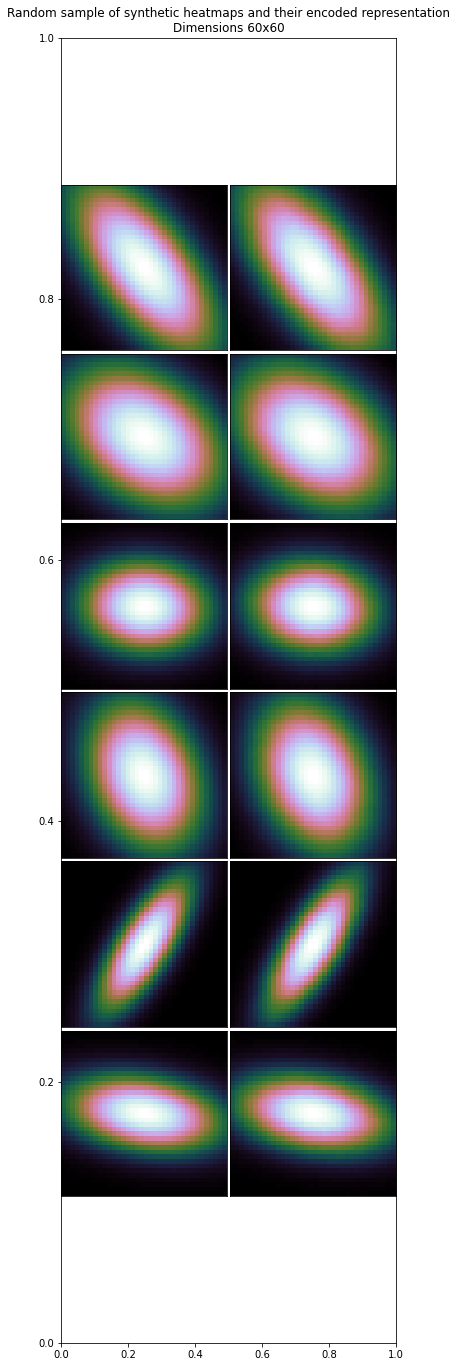

In [ ]:
## Some Encoded examples
np.random.seed(17)
fig, axis = plt.subplots(1,1,figsize=(6,24))
cvals2 = np.random.randint(0, x_test.shape[0], size = 6)
new_arr = np.stack([x_test[cvals2,::], ae_predict[cvals2,::]]).reshape((12,  36 , 36), order = 'F')
new_arr.shape
plot_grid(fig, axis, new_arr, (6, 2),\
          "Random sample of synthetic heatmaps and their encoded representation\nDimensions {0}x{0}".format(36),\
          cmap = "cubehelix")

In [ ]:
vae_rec_error[:10]

array([0.5624946 , 0.33342826, 0.20232351, 0.44345537, 0.23986624,
       0.31435266, 0.24462408, 0.5061352 , 0.19716164, 0.34104943],
      dtype=float32)

In [ ]:
ae_rec_error[:10]

array([0.1627167 , 0.4810033 , 0.19869559, 0.26325428, 0.24211708,
       0.28482962, 0.32409564, 0.18447168, 0.27882656, 0.31509858],
      dtype=float32)

### Exploration of latent space for the Autoencoder

#### 2D

In [ ]:
## Recover latent space created by AE
z_ae = encoder_t.predict(x_train)

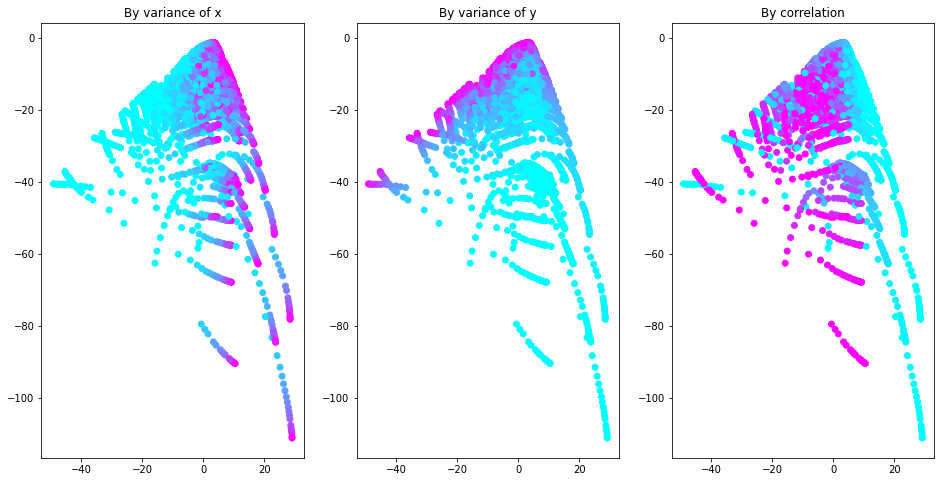

In [ ]:
twod_plot(0, 1, z_ae)

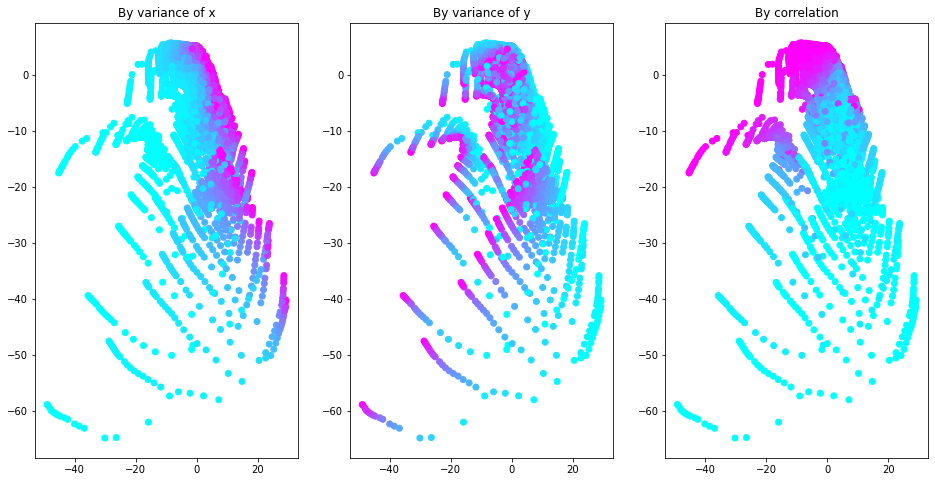

In [ ]:
twod_plot(0, 2, z_ae)

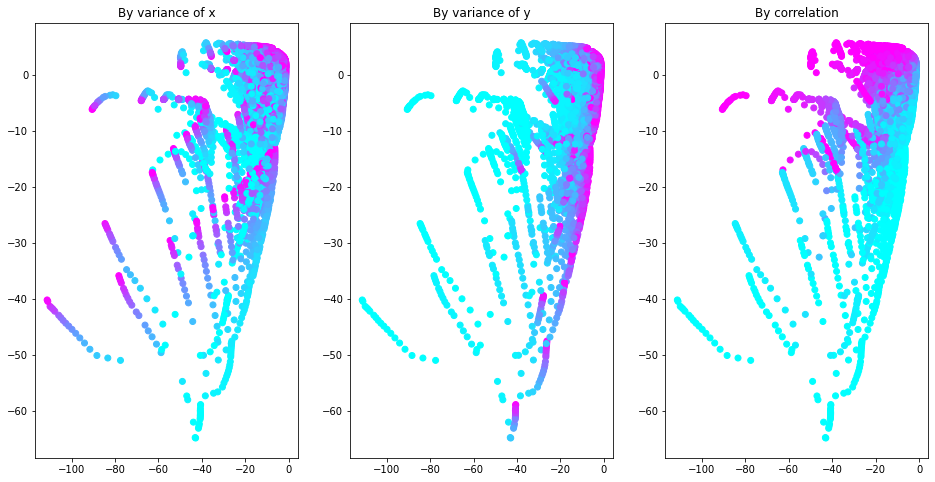

In [ ]:
twod_plot(1, 2, z_ae)

Plots above show projections over the cartesian axis in the latent space generated by the AE. As in the case of the VAE we see that the correlation is the characteristic that is easier to infer in the latent space. Projections also show that in contrast to the results of the VAE the latent space of the AE is less dense and has more gaps between points.  

##### Lines on 0-2 axis

In [ ]:
# AE exploration

## Initial point
base = np.array([15, 0, -20])

## Direction
dir_ae = np.array([-1, 0, 0.7])
dir_ae = dir_ae / np.linalg.norm(dir_ae)
span = 35

## Pair of Vectors
z1 = dir_ae + base
z2 = dir_ae * span + base
size_traj = 6

## Define trajectories
traj = create_trajectory(z1, z2, size_traj)

## Generate images in the trajectory
images_gen = np.squeeze(generate_images([decoder_t], traj))

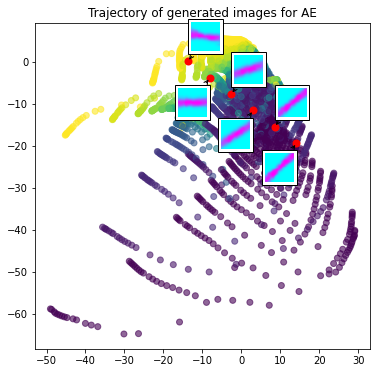

In [ ]:
fig, ax = plt.subplots(1,1, figsize = (6,6))
title = "Trajectory of generated images for {1}".format(size_traj, "AE")
a = plot_data_and_generated_images(ax, z_ae, (0,2), y_train[:,2], traj,\
                               images_gen, alternating,\
                                cmap_points = "viridis", alpha_points = 0.6, c_samples='r',
                               title = title, off = 30)
plt.show()

When trying to transverse the projection space on the 0-2 axis some problems start to emerge. We note that due to the high amount of gaps and lack of density reconstructed images don't look similar to the original data. In this particular case, while the direction encodes a certain form of rotation shown images are not ellipses as the original data.

##### Lines on 0-1 axis

In [ ]:
## Rotation trajectory
z1, theta, size_traj = np.array([50, -100, 0]), np.pi/180 * 80, 5
base = np.array([5, -150, 0])
traj = create_trajectory_rotation(z1, theta, size_traj, base, missing = "z") / 10

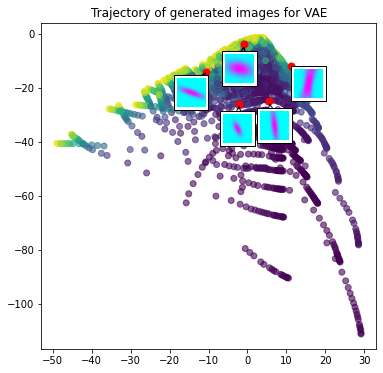

In [ ]:
## Generate images in the trajectory
images_gen = np.squeeze(generate_images([decoder_t], traj))

fig, ax = plt.subplots(1,1, figsize = (6,6))
title = "Trajectory of generated images for {1}".format(size_traj, "VAE")
a = plot_data_and_generated_images(ax, z_ae, (0, 1), y_train[:,1], traj,\
                               images_gen, lambda points, i: points[i]/np.linalg.norm(points[i])*0.5,\
                                cmap_points = "viridis", alpha_points = 0.6, c_samples='r',
                               title = title, off = 50)
plt.show()

Again images can be seen to rotate along the trajectory but the shapes are very different to the original input data. Results suggest that the ability of the AE to generate new samples from empty points in the latent space is poor in comparison with the previous results obtained with the VAE.

#### 3D

##### Interactive Plots

In [ ]:
## Create dataframe to build interactive plot 
df = pd.DataFrame(z_ae)
df = pd.concat([df, pd.DataFrame(y_train)], axis=1)
df.columns = ["x", "y", "z", "var_x", "var_y", "cor"]
df["diff"] = np.abs(df.var_x - df.var_y)


In [ ]:
fig = px.scatter_3d(df, x='x', y='y', z='z',
              color='cor')
fig.show()

In [ ]:
fig = px.scatter_3d(df, x='x', y='y', z='z',
              color='diff')
fig.show()

#### Convex Hull

It is important to note that similar to the results of the VAE the convex hull of the manifold created by the AE also shares a isovariance thin line. In general the shape of the figure is very similar between both, except for the density of the points. Perhaps another difference is the use of parabolas to encode a couple of particular points for the AE.

In this section I take some points on the convex hull and generate some random perturbations to check how these affect the decoded result. 

In [ ]:
## There's a thin line that moves along the convex hull we are interested in those points
use_data = df[df["diff"] <= 0.2].sort_values("x")
use_data["xdiscr"] = pd.cut(use_data.x, 200)

In [ ]:
## Take out the max by bin in order to get the values in the hull
hull_data = use_data[["x","y", "xdiscr", "z"]].groupby("xdiscr").agg({'x':'mean','y':'max','z':'mean'})
hull_data = hull_data.sort_values(["x"])
hull_data = hull_data[~np.isnan(hull_data.x)]

In [ ]:
## Generate minor perturbations on the hull points to check their decoded versions
vec_pool = hull_data[(hull_data.x > 0) & (hull_data.x < 9)]
vec_pool.loc[:, "y"] -= np.abs(np.random.normal(0, 0.2, vec_pool.shape[0]))
vec_pool.loc[:, "z"] += np.random.normal(0, 0.3, vec_pool.shape[0])

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1781: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
np.random.seed(15)
new_trajs = vec_pool.sample(12).to_numpy()

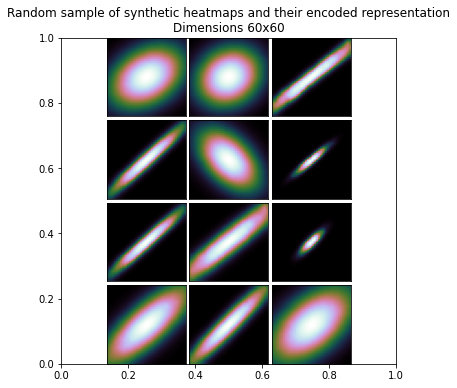

In [ ]:
## Generating from the special direction
images_gen = np.squeeze(generate_images([decoder_t], new_trajs))
fig, axis = plt.subplots(1,1,figsize=(6, 6))
plot_grid(fig, axis, images_gen, (4, 3),\
          "Random sample of synthetic heatmaps and their encoded representation\nDimensions {0}x{0}".format(36),\
          cmap = "cubehelix")

We note that near the convex hull the space is more dense hence we don't see the type of problems that we had when we were transversing the projection space. Namely, there are not many empty spaces along the trajectories chosen. Hence, decoded results are still similar to the original data.

### Transversing empty space

By analyzing the manifold we can see that it has some parabola shaped tails. For this section I decided to transverse the totally empty space that joins the left tail and the right one through the back of the manifold.

In [ ]:
z1 = np.array([-24.6544, -20.80492, -27.71859])
#18.04459, -62.88085, -17.4111
z2 = np.array([11.77235, -47.55777, -19.09448])
trajs = create_trajectory(z1, z2, 12)
trajs

array([[ 11.77235   , -47.55777   , -19.09448   ],
       [  8.46082727, -45.12569273, -19.87849   ],
       [  5.14930455, -42.69361545, -20.6625    ],
       [  1.83778182, -40.26153818, -21.44651   ],
       [ -1.47374091, -37.82946091, -22.23052   ],
       [ -4.78526364, -35.39738364, -23.01453   ],
       [ -8.09678636, -32.96530636, -23.79854   ],
       [-11.40830909, -30.53322909, -24.58255   ],
       [-14.71983182, -28.10115182, -25.36656   ],
       [-18.03135455, -25.66907455, -26.15057   ],
       [-21.34287727, -23.23699727, -26.93458   ],
       [-24.6544    , -20.80492   , -27.71859   ]])

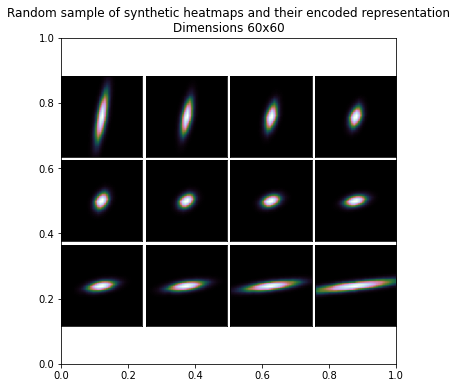

In [ ]:
## Generating from the special direction
images_gen = np.squeeze(generate_images([decoder_t], trajs))
fig, axis = plt.subplots(1,1,figsize=(6, 6))
plot_grid(fig, axis, images_gen, (3, 4),\
          "Random sample of synthetic heatmaps and their encoded representation\nDimensions {0}x{0}".format(36),\
          cmap = "cubehelix")

We see that while the direction still has a meaning namely increasing variance of the second component vs decreasing variance in the first one. Reconstructed images still look very different to the original ones. 

# General Discussion of results

**Directions of the latent space for the VAE**
* Projections of the manifold in 2D show that the correlation is easily separable both in the original space and in the projected one. 
* There is a slight evidence that the variances are also separable in the projection space. However, evidence is definitely stronger in the original latent space.  
* Directions that transverse from north to south over the convex hull are related to decreases in the correlation. That is, rotations on the ellipse seen on the heatmaps.
* If we move from the west to the east transversing in diagonal across the space and starting from the convex hull to end in the back of the manifold we get a direction in which the variance of the first component increases. The analagous path that goes from the eastern side of the convex hull to the west accross the manifold is a direction in which the variance of the second component increases. Hence this two dimensions are related to lengthening and widening of the ellipse.
* Points in the outside represent easily distinguishable images such as those in which variances are very unequal.

**Shape of the manifold that is created in the latent space**
* Its not surprising the figure that the VAE uses to encode the points has a piramidal shape and ends in a sharp point. This characteristic is due to the fact that the transformation from the original covariance matrix to the heatmaps is barely one to one when the variance is the maximum in both components. This happens because rotations in the ellipse when both components are maxed out are very hard to distinguish given the proposed grid (-3 to 3) hence all this points get mapped near each other and are very hard to identify (think on trying to rotate a circle, for example). The opposite happens when the variance between the components is highly unequal because then the ellipse resembles a stick and rotations are very easy to distinguish hence these points are mapped to the tails of the manifold far away from other points. 

**Diferences that arise when comparing with an Autoencoder**
* We note that the latent space generated by the regular AE has a similar interpretation as the one of the VAE. Correlation is encoded in north-south directions while increasing/decreasing variances appear upon moving to the sides. 
* The latent space of the AE is much more sparse and less dense than the one of the VAE. It spans a greater range in all axes and there are several empty regions between points. This sparseness is perjudicial in the sense that when decoding points taken from the empty regions we don't get images similar to the originals. 
* Sparseness is particularly problematic when trying to decode points that arise when taking projections on 2D planes since the plane to which the points are projected might be located in an empty region. Hence, decoded points keep latent traits but are not similar to the original inputs.
* When comparing reconstruction errors we note that the AE has on average a lower reconstruction error than the VAE. However, this is not as positive as it appears because of two reasons. The first is that in high dimensional settings the frobenius norm is hard to interpret as pointed in Doersch, C. (2016). The difficulty in the interpretation arises because for example translations and rotations of a given image have a high distance to the original according to this metric but are not very different in terms of visual appeareance. The second is that while it is true that on average the AE is better, the distribution of the reconstruction error for this method is more skewed than for the VAE. This fact suggests that there are certain images in the test set which end up being located in empty spaces of the latent space when all the training data is used.





## Extension to a four dimensional problem

## Data generation

In this part I extend the results of the sections before by considering data that has four inherent characteristics and not three. Projections are still done on a 3-dimensional latent space. Instead of considering only the density of a bivariate normal distribution for this section I consider heatmaps generated by multivariate t-distributions with $2$ or $200$ degrees of freedom. The degrees of freedom are assigned according to the following stochastic equation $|x + y|^2 - l > 20$ where $l$ is a random variable taken from a $U(0,10)$ and $x, y$ represent the variances of the first and second components respectively.

The rest of the data generating process is carried out in the same manner as in the section before. 



In [ ]:
## Now we create observations from a multivariate t-distribution or an almost normal according 
## to a probabilistic rule. 
import numpy as np
from math import *

def multivariate_t_distribution(x, mu, Sigma, df):
    '''
    Multivariate t-student density. Returns the density
    of the function at points specified by x.

    input:
        x = parameter (n-d numpy array; will be forced to 2d)
        mu = mean (d dimensional numpy array)
        Sigma = scale matrix (dxd numpy array)
        df = degrees of freedom
    '''

    x = np.atleast_2d(x) # requires x as 2d
    nD = Sigma.shape[0] # dimensionality

    numerator = gamma(1.0 * (nD + df) / 2.0)

    denominator = (
            gamma(1.0 * df / 2.0) * 
            np.power(df * np.pi, 1.0 * nD / 2.0) *  
            np.power(np.linalg.det(Sigma), 1.0 / 2.0) * 
            np.power(
                1.0 + (1.0 / df) *
                np.diagonal(
                    np.dot( np.dot(x - mu, np.linalg.inv(Sigma)), (x - mu).T)
                ), 
                1.0 * (nD + df) / 2.0
                )
            )

    return 1.0 * numerator / denominator 

In [ ]:
def simulate_distr(varx, vary, cor, df = 5):
    ## Create Varcov Matrix
    mu = np.array([0, 0])
    vc = np.array([[varx, cor * np.sqrt(varx) * np.sqrt(vary)], [cor * np.sqrt(varx) * np.sqrt(vary), vary]])
    
    ## Grid for density evaluation
    x, y = np.mgrid[-3:3:.17, -3:3:.17] ## Image quality
    pos = np.dstack((x, y))
    val = []
    for row in pos:
      val.append(multivariate_t_distribution(row, mu = mu, Sigma = vc, df = df))
    val = np.array(val)  
    nv = val/np.max(val)
    ## Show Plot
    # plt.imshow(nv)
    return nv

In [ ]:
a, b = simulate_distr(2, 3, 0.5, df = 2), simulate_distr(2, 3, 0.5, df = 200)

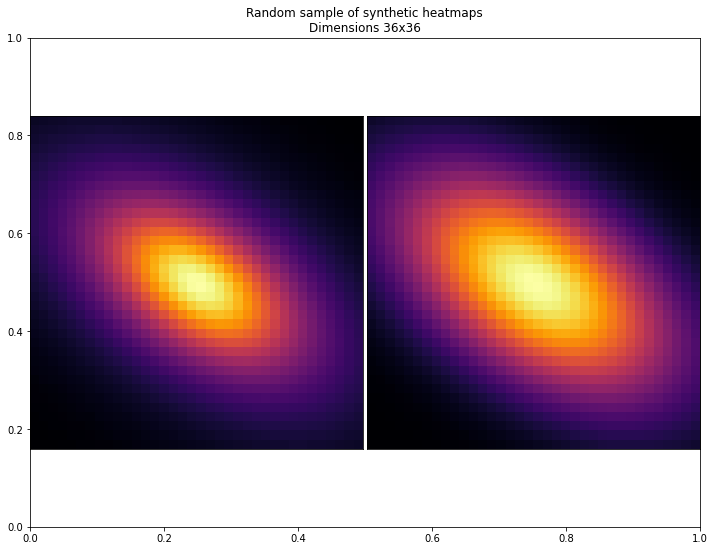

In [ ]:
## Comparing t-2 vs t-200
fig, axis = plt.subplots(1,1,figsize=(12,9))
plot_grid(fig, axis, np.array([a, b]), (1,2),\
          "Random sample of synthetic heatmaps\nDimensions {0}x{0}".format(36),\
          cmap = "inferno", switch = False)

In [ ]:
## Define grids for variance - correlation
var_grid = np.arange(0.1, 5, .2)
cor_grid = np.arange(-0.95, 0.95, 0.1)

## All combinations
mesh = np.array(np.meshgrid(var_grid, var_grid, cor_grid))
combinations = mesh.T.reshape(-1, 3)
combinations.shape

## Select dfs 
luck = np.random.uniform(0, 10, combinations.shape[0])
val = np.power(np.abs(combinations[:,0] + combinations[:,1]), 2) - luck > 20
#dfs = np.logical_and(luck, val)
dfs = val
print(np.mean(dfs))
labs = np.where(dfs, 2, 200)

new_combs = np.hstack([combinations, labs.reshape((combinations.shape[0],1))])

# Simulate
all_ims = []
for elem in new_combs:
  im = simulate_distr(*elem)
  all_ims.append(im)

all_ims = np.array(all_ims)

0.5002947368421052


In [ ]:
all_ims.shape

(11875, 36, 36)

### Data Preprocessing and validation


In [ ]:
np.random.seed(25)
x_train, x_test, y_train, y_test = train_test_split(all_ims.astype("float32"), new_combs, test_size = 0.2, random_state = 19)

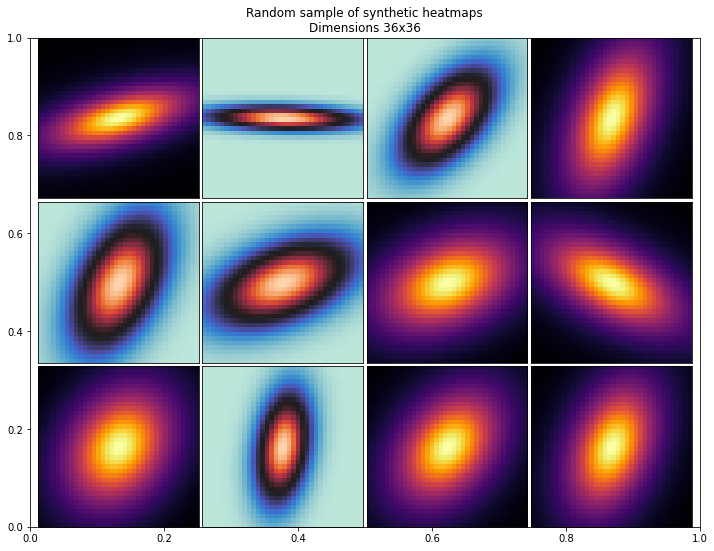

In [ ]:
fig, axis = plt.subplots(1,1,figsize=(12,9))
cvals = np.random.randint(0, x_train.shape[0], size = 12)
plot_grid(fig, axis, x_train[cvals,::], (3,4),\
          "Random sample of synthetic heatmaps\nDimensions {0}x{0}".format(36),\
          cmap = ["inferno", "icefire"], switch = y_train[cvals,3] == 2)

The plot above shows a sample of the generated images colored by whether they were created by the t-distribution with 2 degrees of freedom or 200.

### Variational autoencoder architecture

The architecture used in this part resembles the one used in the section before.

In [ ]:
latent_dim = 3

In [ ]:
## Encoder architecture
inputs = keras.Input(shape=(36, 36, 1))
e_step = Conv2D(32, 3, activation="relu", strides=1, padding="same")(inputs)
e_step = gen_block(e_step, 64)
e_step = gen_block(e_step, 128)
e_step = gen_block(e_step, 64, stride = 2)
e_step = Flatten()(e_step)
h = Dense(64, activation='relu')(e_step)
z_mean = Dense(latent_dim)(h)
z_log_sigma = Dense(latent_dim)(h)
z = layers.Lambda(Sample)([z_mean, z_log_sigma])
encoder_l = keras.Model(inputs, [z_mean, z_log_sigma, z], name='encoder_l')
encoder_l.summary()

Model: "encoder_l"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 36, 36, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_13 (Conv2D)              (None, 36, 36, 32)   320         input_6[0][0]                    
__________________________________________________________________________________________________
conv2d_14 (Conv2D)              (None, 36, 36, 64)   18496       conv2d_13[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_9 (MaxPooling2D)  (None, 18, 18, 64)   0           conv2d_14[0][0]                  
__________________________________________________________________________________________

In [ ]:
## Decoder
latent_inputs = keras.Input(shape=(latent_dim,))
d_step = Dense(4 * 4 * 64, activation="relu")(latent_inputs)
d_step = Reshape((4, 4, 64))(d_step)
d_step = Conv2DTranspose(64, 3, activation="relu", strides=1, padding="same")(d_step)
d_step = Conv2DTranspose(64, 3, activation="relu", strides=3, padding="same")(d_step)
d_step = Conv2DTranspose(32, 3, activation="relu", strides=3, padding="same")(d_step)
d_output = Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(d_step)
decoder_l = keras.Model(latent_inputs, [d_output], name="decoder_l")
decoder_l.summary()

Model: "decoder_l"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 3)]               0         
_________________________________________________________________
dense_11 (Dense)             (None, 1024)              4096      
_________________________________________________________________
reshape_1 (Reshape)          (None, 4, 4, 64)          0         
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 4, 4, 64)          36928     
_________________________________________________________________
conv2d_transpose_5 (Conv2DTr (None, 12, 12, 64)        36928     
_________________________________________________________________
conv2d_transpose_6 (Conv2DTr (None, 36, 36, 32)        18464     
_________________________________________________________________
conv2d_transpose_7 (Conv2DTr (None, 36, 36, 1)         28

In [ ]:
# VAE Model
outputs = decoder_l(encoder_l(inputs)[2])
vae_l = keras.Model(inputs, outputs, name='vae_large')
vae_l.summary()

# VAE Loss
reconstruction_loss = K.mean(keras.losses.binary_crossentropy(inputs, outputs))
reconstruction_loss *= 36 * 36
kl_loss = 1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma)
kl_loss = K.mean(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = reconstruction_loss + kl_loss
vae_l.add_loss(vae_loss)

Model: "vae_large"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 36, 36, 1)]       0         
_________________________________________________________________
encoder_l (Functional)       [(None, 3), (None, 3), (N 232454    
_________________________________________________________________
decoder_l (Functional)       (None, 36, 36, 1)         96705     
Total params: 329,159
Trainable params: 329,159
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Compiling
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    0.001, 30, 0.99, staircase=False, name=None
)
vae_l.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule))

# Fit
vae_l.fit(x_train, x_train,
        epochs=30,
        batch_size=64,
        validation_data=(x_test, x_test),
        callbacks = [])

Epoch 1/30
149/149 [==============================] - 3s 16ms/step - loss: 745.1392 - val_loss: 545.4174
Epoch 2/30
149/149 [==============================] - 2s 15ms/step - loss: 545.6138 - val_loss: 517.2703
Epoch 3/30
149/149 [==============================] - 2s 15ms/step - loss: 520.1350 - val_loss: 484.1352
Epoch 4/30
149/149 [==============================] - 2s 15ms/step - loss: 476.6021 - val_loss: 446.9468
Epoch 5/30
149/149 [==============================] - 2s 15ms/step - loss: 453.5428 - val_loss: 444.5869
Epoch 6/30
149/149 [==============================] - 2s 15ms/step - loss: 450.1174 - val_loss: 443.1545
Epoch 7/30
149/149 [==============================] - 2s 15ms/step - loss: 449.7870 - val_loss: 442.7169
Epoch 8/30
149/149 [==============================] - 2s 15ms/step - loss: 447.7513 - val_loss: 442.6017
Epoch 9/30
149/149 [==============================] - 2s 15ms/step - loss: 448.3805 - val_loss: 442.3353
Epoch 10/30
149/149 [==============================] - 

In [ ]:
vae_l.fit(x_train, x_train,
        epochs=10,
        batch_size=64,
        validation_data=(x_test, x_test),
        callbacks = [])


Epoch 1/10
149/149 [==============================] - 2s 15ms/step - loss: 447.1677 - val_loss: 440.9971
Epoch 2/10
149/149 [==============================] - 2s 15ms/step - loss: 447.1630 - val_loss: 440.9719
Epoch 3/10
149/149 [==============================] - 2s 15ms/step - loss: 447.1490 - val_loss: 440.9431
Epoch 4/10
149/149 [==============================] - 2s 15ms/step - loss: 447.1617 - val_loss: 440.9681
Epoch 5/10
149/149 [==============================] - 2s 15ms/step - loss: 447.1433 - val_loss: 440.9180
Epoch 6/10
149/149 [==============================] - 2s 15ms/step - loss: 447.1343 - val_loss: 440.9380
Epoch 7/10
149/149 [==============================] - 2s 15ms/step - loss: 447.1288 - val_loss: 440.9265
Epoch 8/10
149/149 [==============================] - 2s 15ms/step - loss: 447.1248 - val_loss: 440.9665
Epoch 9/10
149/149 [==============================] - 2s 15ms/step - loss: 447.1270 - val_loss: 440.9261
Epoch 10/10
149/149 [==============================] - 

In [ ]:
# vae_l.save('/content/drive/My Drive/Colab Notebooks/vae_model_3636Tdistr4.h5', save_format = "tf")
# encoder_l.save('/content/drive/My Drive/Colab Notebooks/encoder_3636TDistr4.h5', save_format = "tf")
# decoder_l.save('/content/drive/My Drive/Colab Notebooks/decoder_3636TDistr4.h5', save_format = "tf")

In [ ]:
latent_dim = 3
vae_l = load_model('/content/drive/My Drive/Colab Notebooks/vae_model_3636Tdistr.h5')
encoder_l = load_model('/content/drive/My Drive/Colab Notebooks/encoder_3636TDistr.h5')
decoder_l = load_model('/content/drive/My Drive/Colab Notebooks/decoder_3636TDistr.h5')

In [ ]:
## Recover latent space for X
z_mean, z_log_var, z_sample = encoder_l.predict(x_train)
z_meant, z_log_vart, z_samplet = encoder_l.predict(x_test)

In [ ]:
y_train[:10,:]

array([[ 4.1e+00,  4.3e+00, -7.5e-01,  2.0e+00],
       [ 1.5e+00,  2.5e+00, -1.5e-01,  2.0e+02],
       [ 9.0e-01,  2.3e+00, -1.5e-01,  2.0e+02],
       [ 9.0e-01,  3.9e+00,  7.5e-01,  2.0e+02],
       [ 2.3e+00,  1.5e+00,  7.5e-01,  2.0e+02],
       [ 1.5e+00,  4.7e+00, -9.5e-01,  2.0e+00],
       [ 3.9e+00,  2.1e+00, -4.5e-01,  2.0e+00],
       [ 1.5e+00,  1.1e+00,  3.5e-01,  2.0e+02],
       [ 4.7e+00,  3.0e-01, -4.5e-01,  2.0e+00],
       [ 1.5e+00,  1.9e+00, -2.5e-01,  2.0e+02]])

#### Interactive plot

In [ ]:
## Create dataframe to build interactive plot 
df = pd.DataFrame(z_sample)
df = pd.concat([df, pd.DataFrame(y_train)], axis=1)
df.columns = ["x", "y", "z", "var_x", "var_y", "cor", "df"]
df["diff"] = np.abs(df.var_x - df.var_y)

df.head()

x         y         z  var_x  var_y   cor     df  diff
0  0.290506 -0.046102 -0.637679    4.1    4.3 -0.75    2.0   0.2
1  0.196737 -0.262445 -0.056366    1.5    2.5 -0.15  200.0   1.0
2  0.357718 -0.100776  0.257181    0.9    2.3 -0.15  200.0   1.4
3  0.123349 -0.644985  0.956045    0.9    3.9  0.75  200.0   3.0
4 -0.594908 -0.255664  0.699745    2.3    1.5  0.75  200.0   0.8

In [ ]:
fig = px.scatter_3d(df, x='x', y='y', z='z',
              color='df', symbol= "df")
fig.show()

As we can see in the figure above, the generated manifold is similar to the one we obtained in before except that the new one has a more oval shaped border instead of conic. 

The information on the degrees of freedom appears to be stored through layers of parabolic 2D figures over the 3D manifold.

#### KNN classifier

After checking the generated manifold I decided to estimate a KNN classifier to check whether a good separation is achieved in the latent space between points that come from the two different distributions. 

In [ ]:
## Knn
neigh = KNeighborsClassifier()
param_grid = {'n_neighbors': np.arange(3, 25)}
knn_gscv = GridSearchCV(neigh, param_grid, cv=5)
knn_gscv.fit(z_sample, y_train[:,3])
knn_gscv.best_params_

{'n_neighbors': 13}

In [ ]:
knn_gscv.best_score_

0.8474736842105264

In [ ]:
neigh_end = KNeighborsClassifier(n_neighbors = 13)
neigh_end.fit(z_sample, y_train[:,3])
nei_preds = neigh_end.predict(z_samplet)

In [ ]:
print(accuracy_score(y_test[:,3], nei_preds))
print(f1_score(np.where(y_test[:,3] == 2, 1, 0), np.where(nei_preds == 2, 1, 0)))

0.8492631578947368
0.8562248995983935


### Autoencoder architecture

A similar analysis is carried for an autoencoder architecture in this section. 

In [ ]:
## Encoder architecture
inputs = keras.Input(shape=(36, 36, 1))
e_step = Conv2D(32, 3, activation="relu", strides=1, padding="same")(inputs)
e_step = gen_block(e_step, 64)
e_step = gen_block(e_step, 128)
e_step = gen_block(e_step, 64, stride = 2)
e_step = Flatten()(e_step)
h = Dense(64, activation='relu')(e_step)
z = Dense(latent_dim)(h)
encoder_lt = keras.Model(inputs, z, name='encoder')
encoder_lt.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 36, 36, 1)]       0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 36, 36, 32)        320       
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 36, 36, 64)        18496     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 18, 18, 64)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 18, 18, 128)       73856     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 9, 9, 128)         0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 9, 9, 64)          7379

In [ ]:
## Decoder architecture
latent_inputs = keras.Input(shape=(latent_dim,))
d_step = Dense(4 * 4 * 64, activation="relu")(latent_inputs)
d_step = Reshape((4, 4, 64))(d_step)
d_step = Conv2DTranspose(64, 3, activation="relu", strides=1, padding="same")(d_step)
d_step = Conv2DTranspose(64, 3, activation="relu", strides=3, padding="same")(d_step)
d_step = Conv2DTranspose(32, 3, activation="relu", strides=3, padding="same")(d_step)
d_output = Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(d_step)
decoder_lt = keras.Model(latent_inputs, [d_output], name="decoder")
decoder_lt.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 3)]               0         
_________________________________________________________________
dense_14 (Dense)             (None, 1024)              4096      
_________________________________________________________________
reshape_2 (Reshape)          (None, 4, 4, 64)          0         
_________________________________________________________________
conv2d_transpose_8 (Conv2DTr (None, 4, 4, 64)          36928     
_________________________________________________________________
conv2d_transpose_9 (Conv2DTr (None, 12, 12, 64)        36928     
_________________________________________________________________
conv2d_transpose_10 (Conv2DT (None, 36, 36, 32)        18464     
_________________________________________________________________
conv2d_transpose_11 (Conv2DT (None, 36, 36, 1)         289 

In [ ]:
# AE Model
outputs = decoder_lt(encoder_lt(inputs))
ae_lt = keras.Model(inputs, outputs, name='ae_lt')
ae_lt.summary()

# AE Loss
reconstruction_loss = K.mean(keras.losses.binary_crossentropy(inputs, outputs))
ae_lt.add_loss(reconstruction_loss)

Model: "ae_lt"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 36, 36, 1)]       0         
_________________________________________________________________
encoder (Functional)         (None, 3)                 232259    
_________________________________________________________________
decoder (Functional)         (None, 36, 36, 1)         96705     
Total params: 328,964
Trainable params: 328,964
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Compiling
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    0.001, 30, 0.98, staircase=False, name=None
)
ae_lt.compile(optimizer=tf.keras.optimizers.Adam())

# Fit
ae_lt.fit(x_train, x_train,
        epochs=20,
        batch_size=64,
        validation_data=(x_test, x_test),
        callbacks = [])

Epoch 1/20
149/149 [==============================] - 2s 11ms/step - loss: 0.5311 - val_loss: 0.3623
Epoch 2/20
149/149 [==============================] - 1s 9ms/step - loss: 0.3590 - val_loss: 0.3447
Epoch 3/20
149/149 [==============================] - 1s 9ms/step - loss: 0.3455 - val_loss: 0.3446
Epoch 4/20
149/149 [==============================] - 1s 9ms/step - loss: 0.3435 - val_loss: 0.3419
Epoch 5/20
149/149 [==============================] - 1s 9ms/step - loss: 0.3463 - val_loss: 0.3412
Epoch 6/20
149/149 [==============================] - 1s 9ms/step - loss: 0.3443 - val_loss: 0.3409
Epoch 7/20
149/149 [==============================] - 1s 9ms/step - loss: 0.3449 - val_loss: 0.3410
Epoch 8/20
149/149 [==============================] - 1s 9ms/step - loss: 0.3448 - val_loss: 0.3408
Epoch 9/20
149/149 [==============================] - 1s 9ms/step - loss: 0.3429 - val_loss: 0.3405
Epoch 10/20
149/149 [==============================] - 1s 9ms/step - loss: 0.3436 - val_loss: 0.340

In [ ]:
ae_lt.fit(x_train, x_train,
        epochs=5,
        batch_size=64,
        validation_data=(x_test, x_test),
        callbacks = [])

Epoch 1/5
149/149 [==============================] - 5s 34ms/step - loss: 0.3491 - val_loss: 0.3458
Epoch 2/5
149/149 [==============================] - 5s 33ms/step - loss: 0.3492 - val_loss: 0.3459
Epoch 3/5
149/149 [==============================] - 5s 33ms/step - loss: 0.3490 - val_loss: 0.3458
Epoch 4/5
149/149 [==============================] - 5s 33ms/step - loss: 0.3491 - val_loss: 0.3457
Epoch 5/5
149/149 [==============================] - 5s 32ms/step - loss: 0.3492 - val_loss: 0.3457


In [ ]:
# ## Saving AE
# ae_lt.save('/content/drive/My Drive/Colab Notebooks/ae_lt_model_3636N.h5', save_format = "tf")
# decoder_lt.save('/content/drive/My Drive/Colab Notebooks/decoder_lt_model_3636N.h5', save_format = "tf")
# encoder_lt.save('/content/drive/My Drive/Colab Notebooks/encoder_lt_model_3636N.h5', save_format = "tf")

In [ ]:
## Load Models
ae_lt = load_model('/content/drive/My Drive/Colab Notebooks/ae_lt_model_3636.h5')
encoder_lt = load_model('/content/drive/My Drive/Colab Notebooks/encoder_lt_model_3636.h5')
decoder_lt = load_model('/content/drive/My Drive/Colab Notebooks/decoder_lt_model_3636.h5')

In [ ]:
## Recover latent space created by AE
z_ae = encoder_lt.predict(x_train)
z_aet = encoder_lt.predict(x_test)

#### Interactive plot

In [ ]:
## Create dataframe to build interactive plot 
df = pd.DataFrame(z_ae)
df = pd.concat([df, pd.DataFrame(y_train)], axis=1)
df.columns = ["x", "y", "z", "var_x", "var_y", "cor", "df"]
df["diff"] = np.abs(df.var_x - df.var_y)

df.head()

x          y         z  var_x  var_y   cor     df  diff
0   0.306658  -1.623120 -6.551488    4.1    4.3 -0.75    2.0   0.2
1   2.036824   1.212663 -4.188671    1.5    2.5 -0.15  200.0   1.0
2   2.759686   2.484865 -6.141192    0.9    2.3 -0.15  200.0   1.4
3   5.832178  10.861330 -3.836106    0.9    3.9  0.75  200.0   3.0
4  11.117862   3.659466 -2.258841    2.3    1.5  0.75  200.0   0.8

In [ ]:
fig = px.scatter_3d(df, x='x', y='y', z='z',
              color='df', symbol= "df")
fig.show()

#### KNN classifier

In [ ]:
## Knn
neigh = KNeighborsClassifier()
param_grid = {'n_neighbors': np.arange(3, 25)}
knn_gscv = GridSearchCV(neigh, param_grid, cv=5)
knn_gscv.fit(z_ae, y_train[:,3])
knn_gscv.best_params_

{'n_neighbors': 3}

In [ ]:
knn_gscv.best_score_

0.8563157894736841

In [ ]:
neigh_end = KNeighborsClassifier(n_neighbors = 13)
neigh_end.fit(z_ae, y_train[:,3])
nei_preds = neigh_end.predict(z_aet)

In [ ]:
print(accuracy_score(y_test[:,3], nei_preds))
print(f1_score(np.where(y_test[:,3] == 2, 1, 0), np.where(nei_preds == 2, 1, 0)))

0.8471578947368421
0.8560095200317335


# General Discussion of results 

For this last part, images that have four inherent dimensions were created but embedded in a 3D latent space using both the VAE and the AE in order to compare the results obtained. The result is tractable as the fourth dimension depends almost completely on the others, namely depends on the sum of the variances plus an error. Hence, what we are in fact looking for is whether the methods can discover this pattern.

* For both the methods we note that the four dimension gets encoded through parabolic layers along the center of the manifold and over the convex hull. Results obtained suggest that both methods can detect the relation and work as non-linear dimensionality reduction methods. 
* When comparing the accuracy and the F1 score obtained by using a classifier on the latent space to separate points from the two classes we note that both methods perform similarly. In particular, metrics obtained in both cases are very close between them. 
* The shape of the manifold is slightly modified in both cases when compared with the one obtained in the section before. In particular the figure becomes less sharp and more oval shaped in the end. This reflects the fact the this new dimension reduces slightly the problem of non 1-1 relations that ocurr when both components have high variances.



# Conclusion

An exploration of the latent space induced by a variational autoencoder is done in a particular data example and compared with results obtained through a traditional autoencoder. The data is created by evaluating the density of a bivariate normal distribution in a $36\times36$ grid between $-3$ and $3$ for different covariance matrices and presenting results as heatmaps. 

More than eleven thousand images are generated with varying degrees of correlation and variance in both components according to a fixed grid of parameters. The data is split in a train and test set. 

The architecture of the VAE follows basic principles in the image recognition literature using convolutional, transpose convolutional, max pooling and fully connected layers. Training is done until there is no apparent improvement in validation loss and the optimizer uses a learning rate scheduler. 

Results show that directions in the latent space of the VAE become meaningful as they reflect variations in the three latent characteristics of the images namely variances of the two components and their correlation. In particular we find three particular trajectories that are monotone in these latent traits. The manifold formed by the VAE to embed the original data isn't completely arbitrary. We note that the shape though mostly smooth has a sharp kink reflecting the lack of injectivity in the mapping from the covariance matrices to the heatmaps when the variance is maxed out (modifications in correlations at this point barely change the image).

When comparing the manifolds of the two methods we note that overall the shape is very similar. However, the latent space generated through the autoencoder is much more sparse and has empty regions between points. These regions become problematic when there is interest in decoding points in them as usually results obtained are very different from the original data. The problem is more pervasive when trying to decode points that are obtained through projections in the latent space. The VAE doesn't have this problem. The reconstruction error of both methods shows that on average the reconstruction is better with the autoencoder however the distribution of the error is skewed showing again the high magnitude mistakes that happen when decoding points in empty regions of the space. 


Extending the problem with data that has four inherent characteristics. We note that both methods can act as non-linear dimensionality reduction methods. The information of the fourth trait (in this case coming from a particular class) is kept in the latent space representation. In particular, a classified based on the latent space points achieves similar accuracy and F1 score for both methods. 

It would be interesting to extend this project by considering further refinements of metrics to compare decoded images against the original ones instead of using the frobenius distance. In fact, using metrics that are invariant to translations and rotation could prove to be much more useful. Some further research could be done on how to compare generated images obtained by decoding random points in the latent space on the grounds of whether they are similar to what we expect to obtain and if it can be said that they come from the same distribution as the original data. 

# References
Doersch, C. (2016). Tutorial on variational autoencoders. arXiv preprint arXiv:1606.05908.

Klys, J., Snell, J., & Zemel, R. (2018). Learning latent subspaces in variational autoencoders. arXiv preprint arXiv:1812.06190.

Kingma, D. P., & Welling, M. (2013). Auto-encoding variational bayes. arXiv preprint arXiv:1312.6114.

Leonov, S., Vasilyev, A., Makovetskii, A., & Kober, V. (2019
). Analysis of the convolutional neural network architectures in image classification problems. In Applications of Digital Image Processing XLII (Vol. 11137, p. 111372E). International Society for Optics and Photonics.

